# Road Accident Severity Analysis

In this notebook, we conduct an end-to-end analysis of UK road accident data (2023) to investigate factors associated with accident severity and build predictive models. 

Our goal is to:

- Explore patterns in accident occurrence and severity
- Build machine learning models to predict accident severity
- Identify geospatial accident hotspots using clustering

Rather than applying models blindly, we take an iterative, data-driven approach — examining data distributions, testing hypotheses, and adapting our strategy in response to results. Each decision in this notebook is grounded in reasoning, domain relevance, and a desire to improve real-world safety outcomes.

We structure our analysis as follows:
- Understand the structure, quality, and limitations of the dataset
- Clean and transform the data to prepare it for modelling
- Engineer meaningful features capturing temporal, environmental, and spatial patterns
- Build and evaluate multiple predictive models, accounting for class imbalance
- Explore advanced methods (SMOTE, class weighting, tuning) to improve performance
- Analyse geospatial clustering to identify accident hotspots

Authors 
- Lukshan Sharvaswaran
- Shubhankar Shahade
- Qing Wang

A venv was created for this project. We highly reccomend that the venv is activated and use the python installation inside as the kernel.


Please note - the dataset is too large to be included with the submission. 
Data can be downloaded at this link. The code will attempt to download the data automatically

https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-accidents-safety-data/datafile/12afeb69-4edc-435f-b4d0-7cc84deed987/preview

In [123]:
# print python version
! pip install -r requirements.txt


Python 3.13.2


In [125]:
print("Python version:")
! python --version

print("\nPackages:")
!pip freeze
# %%


Python version:
Python 3.13.2

Packages:
anyio==4.9.0
appnope==0.1.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.4
bleach==6.2.0
branca==0.8.1
catboost==1.2.8
certifi==2025.4.26
cffi==1.17.1
charset-normalizer==3.4.1
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.0
fastjsonschema==2.21.1
folium==0.19.5
fonttools==4.57.0
fqdn==1.5.1
graphviz==0.20.3
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.10
imbalanced-learn==0.13.0
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.6
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.12.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2025.4.1
jupyter==1.1.1
jupyter-console==6.6.3
jupyter-events==0.12.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.15.0
jupyter_server_terminals==0.5.

In [63]:
# Import required libraries

# Standard and system libraries
import os
import warnings
from pathlib import Path
import logging

# Data processing
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Statistical and correlation analysis
from scipy import stats
from sklearn.decomposition import PCA
from statsmodels.stats.multicomp import MultiComparison

# Machine learning
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from catboost import CatBoostClassifier

# Import required libraries for geospatial analysis
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt


# Optional: SHAP (commented out)
# import shap

# Configure environment
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", context="notebook")

# Create output directories
Path("outputs").mkdir(parents=True, exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

# Debug variables

RUN_DIAGRAMS = True
RUN_MODEL_EXPERIMENTS = True
CREATE_FOLIUM_MAP = True


## 1. Initial Data Inspection

We begin by loading the dataset and exploring its structure to understand what we’re working with.

This involves:
- Checking the shape, data types, and structure of the dataset
- Viewing sample rows and summary statistics
- Identifying missing values and columns that may not add value

This step helps us anticipate potential issues (e.g. data quality, encoding quirks, irrelevant fields) and informs our cleaning strategy later. We also flag columns with:
- Only one unique value (likely not useful)
- High cardinality (e.g. IDs or coordinates)
- Excessive missingness (>95%)

Doing this early prevents wasted effort modelling on features that are uninformative or broken, and sets the foundation for a clean, trustworthy dataset going forward.

In [ ]:
# Check if the file exists
if not os.path.exists('dft-road-casualty-statistics-collision-2023.csv'):
    print("Downloading the dataset...")
    # Download the dataset
    URL = "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-2023.csv"
    import requests
    response = requests.get(URL)
    with open('dft-road-casualty-statistics-collision-2023.csv', 'wb') as file:
        file.write(response.content)


# Load the dataset
df = pd.read_csv('dft-road-casualty-statistics-collision-2023.csv', low_memory=False)

# Display the shape of the dataset
print(f"Dataset shape: Rows = {df.shape[0]}, Columns = {df.shape[1]}")

# Show the first 5 rows
df.head()

Dataset shape: Rows = 104258, Columns = 37


accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  01/01/2023   
1                  3                   3                     2  01/01/2023   
2                  3                   2                     1  01/01/2023   
3                  3                   2                     1  01/01/2023   
4                  3                   2                     1  01/01/2023   

   day_of_week   time  local_authority_district local_authority_ons_district  \
0            1  01:24                        -1                    E09000024   
1            1  02:25                        -1                    E09000010   
2            1  03:50                        -1                    E09000017   
3            1  02:13                        -1                    E09000003   
4            1  01:42                        -1                    E09000032   

  local_authority_highway  first_road_class  first_road_number  road_type  \
0               E09000024                 5                  0          2   
1               E09000010                 6                  0          6   
2               E09000017                 3                437          1   
3               E09000003                 3                  5          6   
4               E09000032                 3               3220          6   

   speed_limit  junction_detail  junction_control  second_road_class  \
0           20                9                 4                  5   
1           30                3                 4                  6   
2           30                1                 4                  6   
3           30                3                 4                  6   
4           30                8                 4                  6   

   second_road_number  pedestrian_crossing_human_control  \
0                   0                                  2   
1                   0                                  0   
2                   0                                  0   
3                   0                                  0   
4                   0                                  0   

   pedestrian_crossing_physical_facilities  light_conditions  \
0                                        5                 4   
1                                        1                 4   
2                                        0                 4   
3                                        0                 4   
4                                        0                 4   

   weather_conditions  road_surface_conditions  special_conditions_at_site  \
0                   8                        2                           0   
1                   1                        1                           0   
2                   1                        1                           0   
3                   9                        1                           0   
4                   1                        1                           0   

   carriageway_hazards  urban_or_rural_area  \
0                    0                  

In [39]:
# Show basic info
df.info()

# Summary stats for numeric columns
df.describe(include=[np.number])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104258 entries, 0 to 104257
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               104258 non-null  object 
 1   accident_year                                104258 non-null  int64  
 2   accident_reference                           104258 non-null  object 
 3   location_easting_osgr                        104246 non-null  float64
 4   location_northing_osgr                       104246 non-null  float64
 5   longitude                                    104246 non-null  float64
 6   latitude                                     104246 non-null  float64
 7   police_force                                 104258 non-null  int64  
 8   accident_severity                            104258 non-null  int64  
 9   number_of_vehicles                           104258 non-nul

accident_year  location_easting_osgr  location_northing_osgr  \
count       104258.0          104246.000000            1.042460e+05   
mean          2023.0          455388.583284            2.754993e+05   
std              0.0           92264.787002            1.466000e+05   
min           2023.0           70537.000000            1.052800e+04   
25%           2023.0          393842.000000            1.748982e+05   
50%           2023.0          462486.500000            2.149055e+05   
75%           2023.0          529489.250000            3.834275e+05   
max           2023.0          655160.000000            1.152174e+06   

           longitude       latitude   police_force  accident_severity  \
count  104246.000000  104246.000000  104258.000000      104258.000000   
mean       -1.204893      52.366984      27.638397           2.745996   
std         1.349407       1.320853      24.321077           0.467638   
min        -7.429339      49.914528       1.000000           1.000000   
25%        -2.093077      51.460339       4.000000           3.000000   
50%        -1.082364      51.819044      22.000000           3.000000   
75%        -0.134329      53.344464      45.000000           3.000000   
max         1.756018      60.252418      99.000000           3.000000   

       number_of_vehicles  number_of_casualties    day_of_week  \
count       104258.000000         104258.000000  104258.000000   
mean             1.820628              1.275461       4.129189   
std              0.689053              0.737006       1.929225   
min              1.000000              1.000000       1.000000   
25%              1.000000              1.000000       3.000000   
50%              2.000000              1.000000       4.000000   
75%              2.000000              1.000000       6.000000   
max             17.000000             70.000000       7.000000   

       local_authority_district  first_road_class  first_road_number  \
count                  104258.0     104258.000000      104258.000000   
mean                       -1.0          4.225565         787.296054   
std                         0.0          1.464022        1578.472251   
min                        -1.0          1.000000           0.000000   
25%                        -1.0          3.000000           0.000000   
50%                        -1.0          4.000000          31.000000   
75%                        -1.0          6.000000         539.000000   
max                        -1.0          6.000000        9176.000000   

           road_type    speed_limit  junction_detail  junction_control  \
count  104258.000000  104258.000000    104258.000000     104258.000000   
mean        5.294222      35.873602         4.632748          1.757745   
std         1.700894      14.349338        14.731899          2.552435   
min         1.000000      20.000000        -1.000000         -1.000000   
25%         6.000000      30.000000         0.000000         -1.000000   
50%         6.000000      30.000000         3.000000          2.000000   
75%         6.000000      40.000000         3.000000          4.000000   
max         9.000000      70.000000        99.000000          9.000000   

       second_road_class  second_road_number  \
count      104258.000000       104258.000000   
mean            3.104155          214.202354   
std             2.763917          916.212958   
min            -1.000000           -1.000000   
25%             0.000000           -1.000000   
50%             3.000000            0.000000   
75%             6.000000            0.000000   
max             6.000000         9999.000000   

       pedestrian_crossing_human_control  \
count                      104258.000000   
mean                            0.509592   
std                             2.094497   
min                            -1.000000   
25%                             0.000000   
50%                             0.000000   
75%                             0.000000   
max          

In [40]:
# Summary stats for categorical columns
df.describe(include=['object', 'category'])

# Missing values (sorted)
missing_values = df.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

location_easting_osgr     12
location_northing_osgr    12
longitude                 12
latitude                  12
dtype: int64

In [41]:
# Identify low-value columns
single_value_cols = []
high_missing_cols = []
high_cardinality_cols = []

for col in df.columns:
    if df[col].dropna().nunique() <= 1:
        single_value_cols.append(col)
    if (df[col].isnull().sum() / len(df)) > 0.95:
        high_missing_cols.append(col)
    if df[col].nunique() > 0.9 * len(df):
        high_cardinality_cols.append(col)

print("Single-value columns:", single_value_cols)
print("High-missing columns (>95% missing):", high_missing_cols)
print("High-cardinality (likely IDs):", high_cardinality_cols)

# Combine all identified low-value columns
low_value_cols = set(single_value_cols + high_missing_cols + high_cardinality_cols)

print("\nAll low-value columns identified in the dataset:")
for col in sorted(low_value_cols):
    print(f"- {col}")

Single-value columns: ['accident_year', 'local_authority_district']
High-missing columns (>95% missing): []
High-cardinality (likely IDs): ['accident_index', 'accident_reference', 'longitude', 'latitude']

All low-value columns identified in the dataset:
- accident_index
- accident_reference
- accident_year
- latitude
- local_authority_district
- longitude


## 1A. Distribution Analysis of Numerical Features

To understand the behaviour of numeric variables, we visualise their distributions. This gives us insights into:

- Central tendency (mean, median)
- Spread (standard deviation)
- Skewness and presence of outliers

This is critical for spotting anomalies and understanding how features might affect modelling — for example, whether scaling or transformation is needed. Highly skewed variables might bias the model, and features with outliers could distort learning. By plotting each feature, we assess whether any preprocessing is required and gain an intuitive feel for how the data behaves.

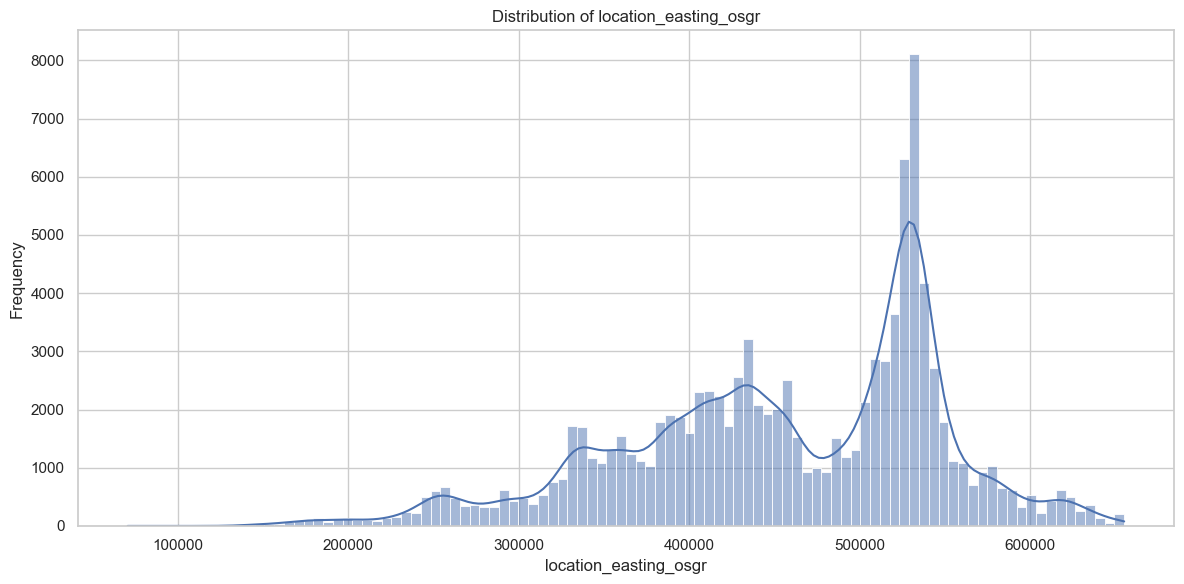

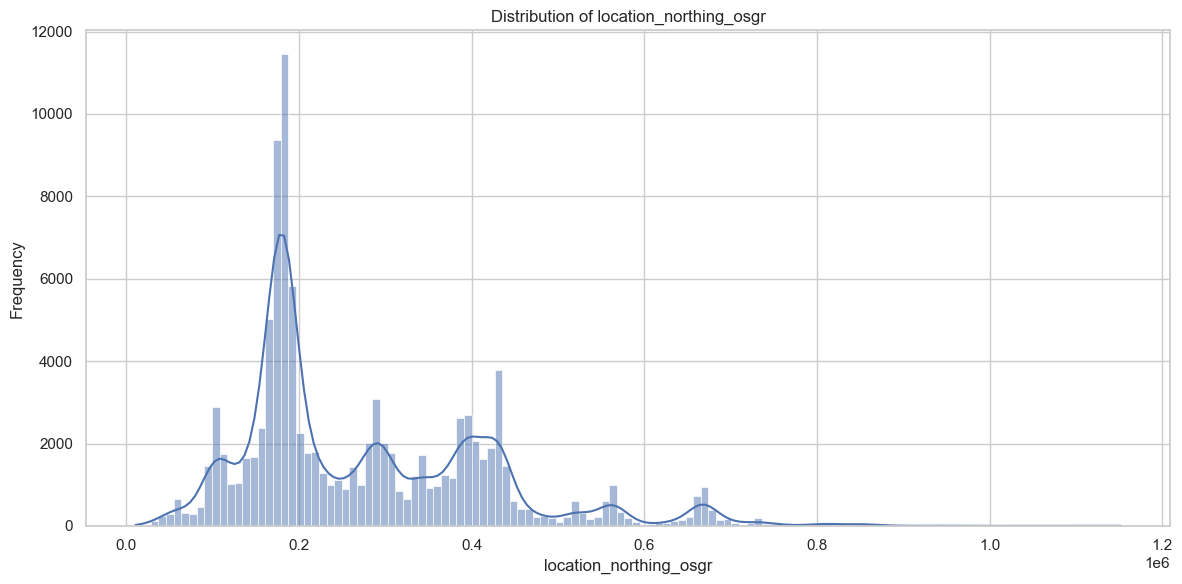

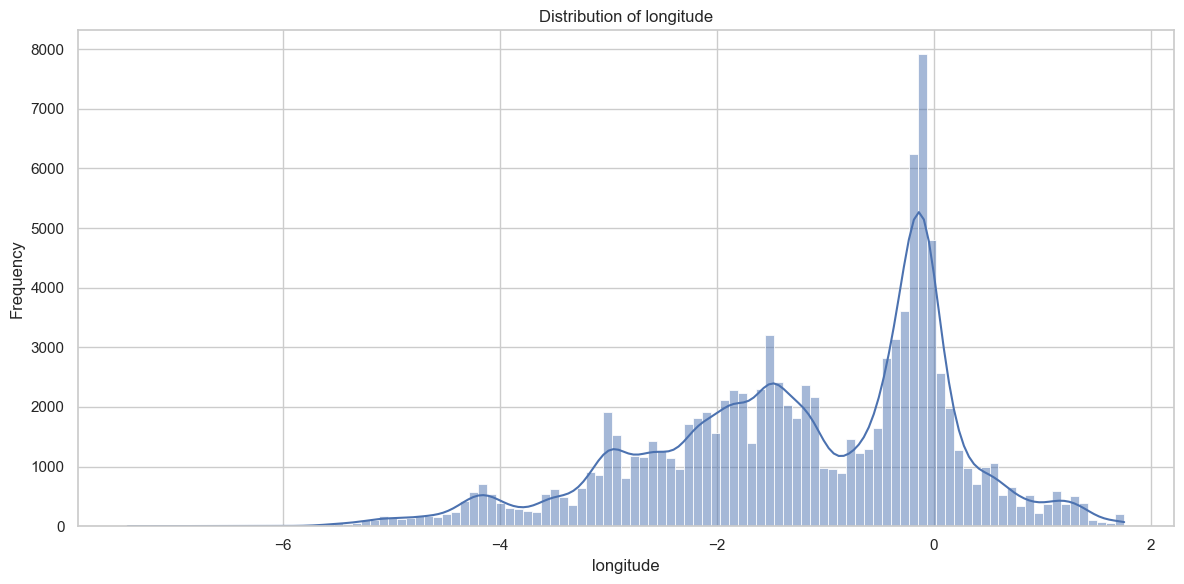

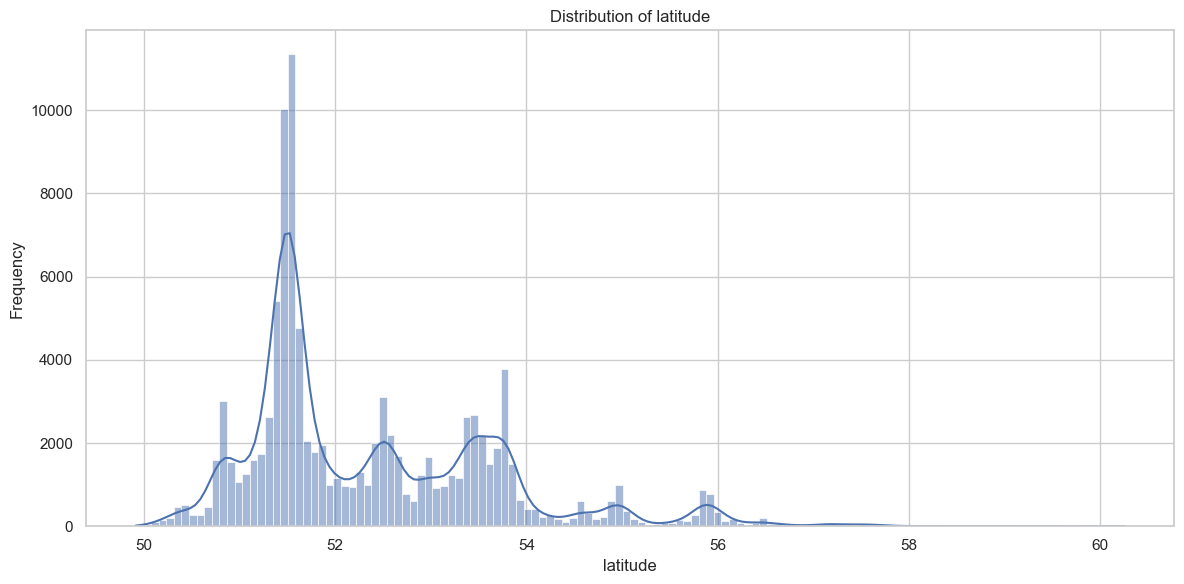

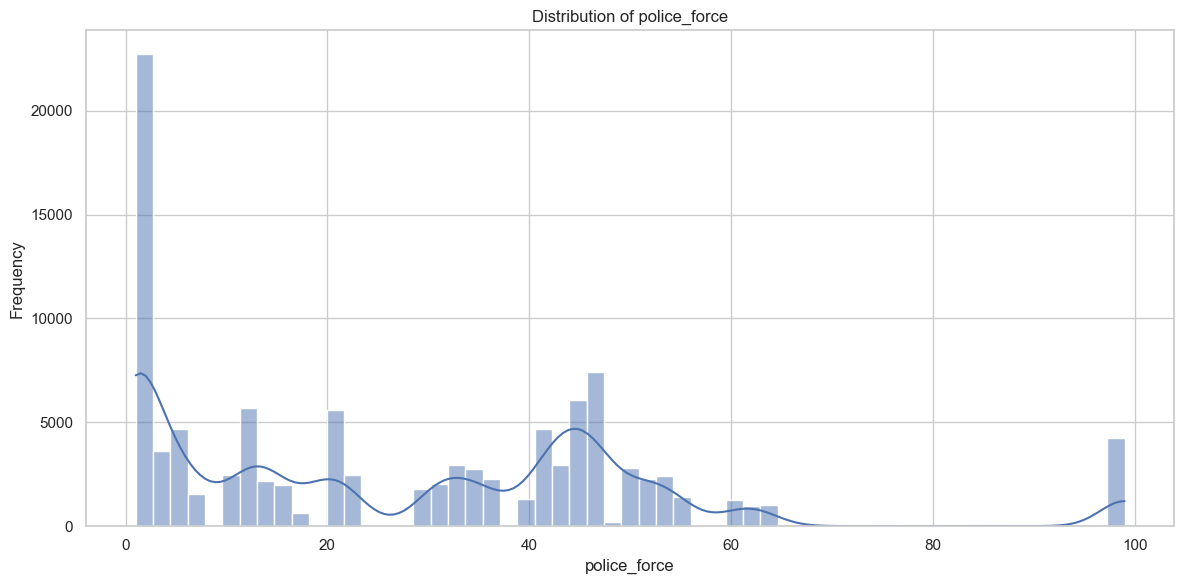

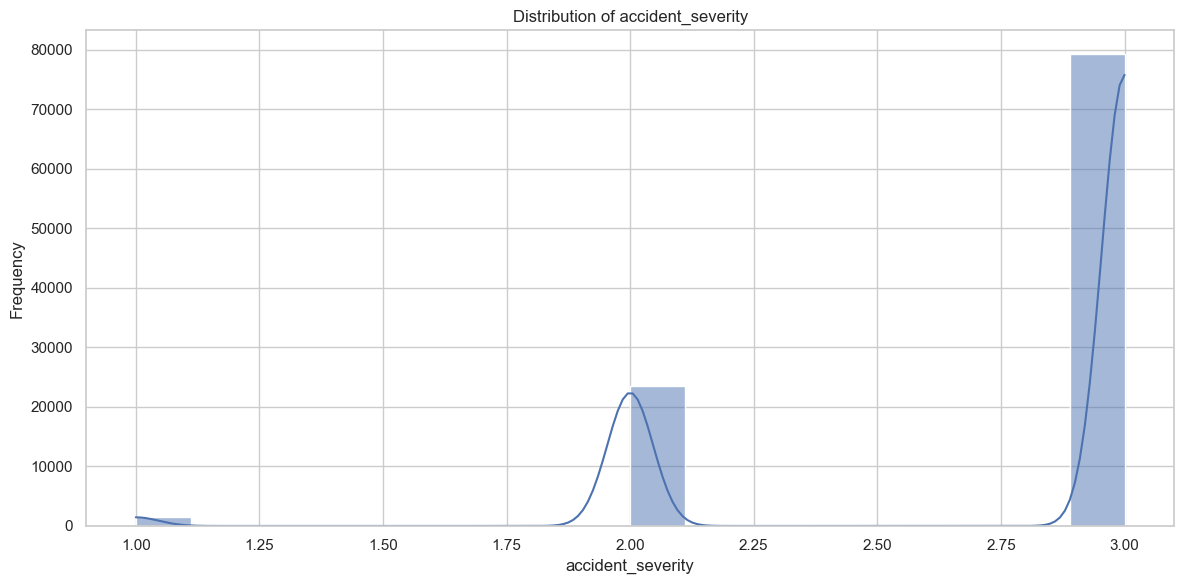

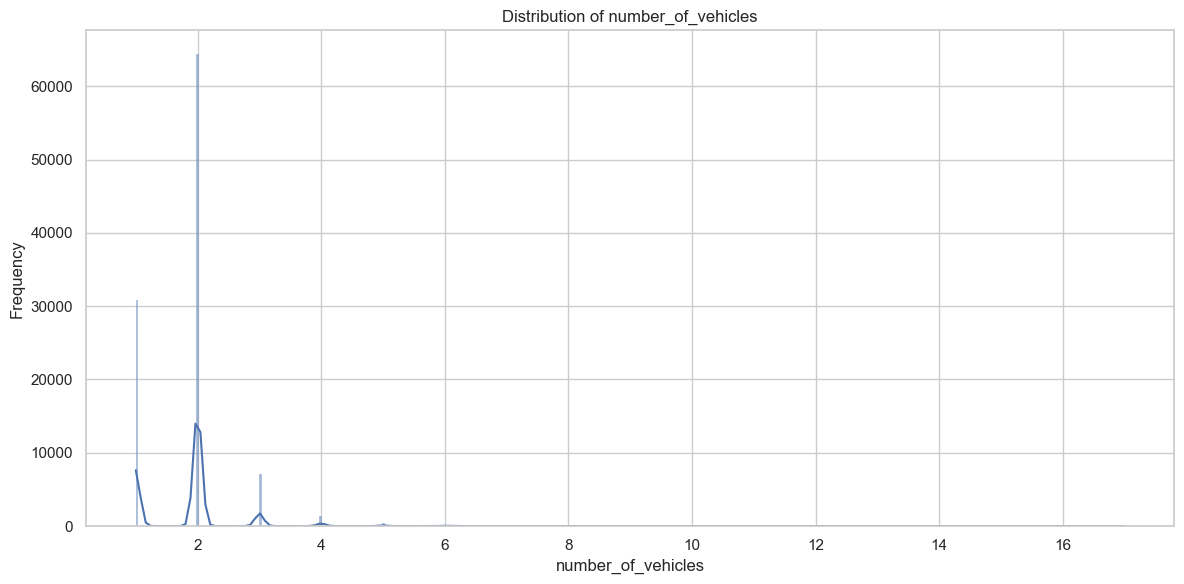

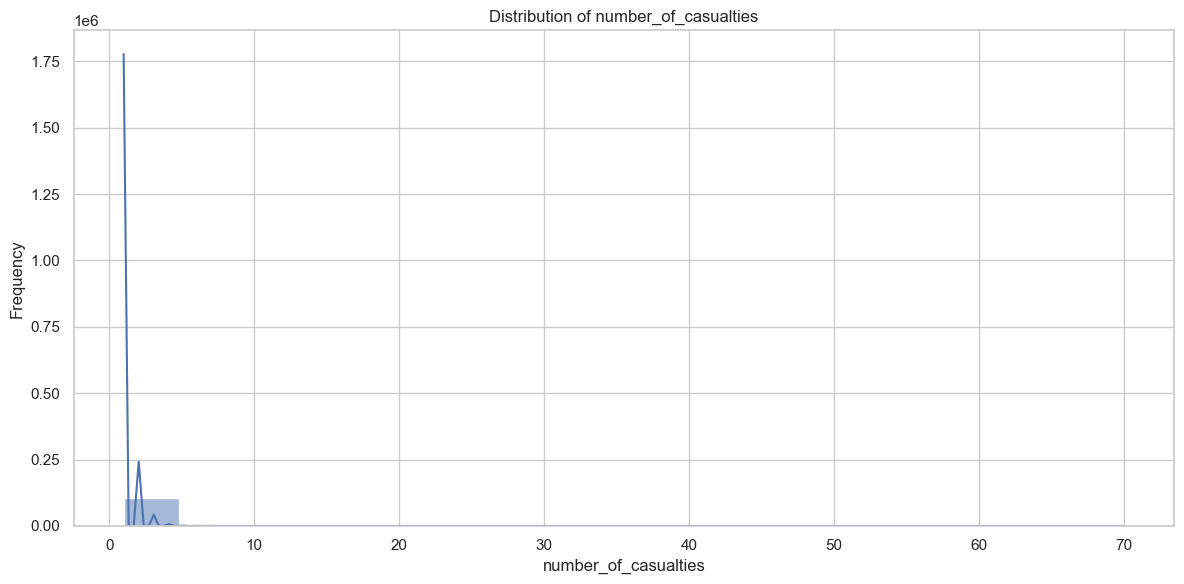

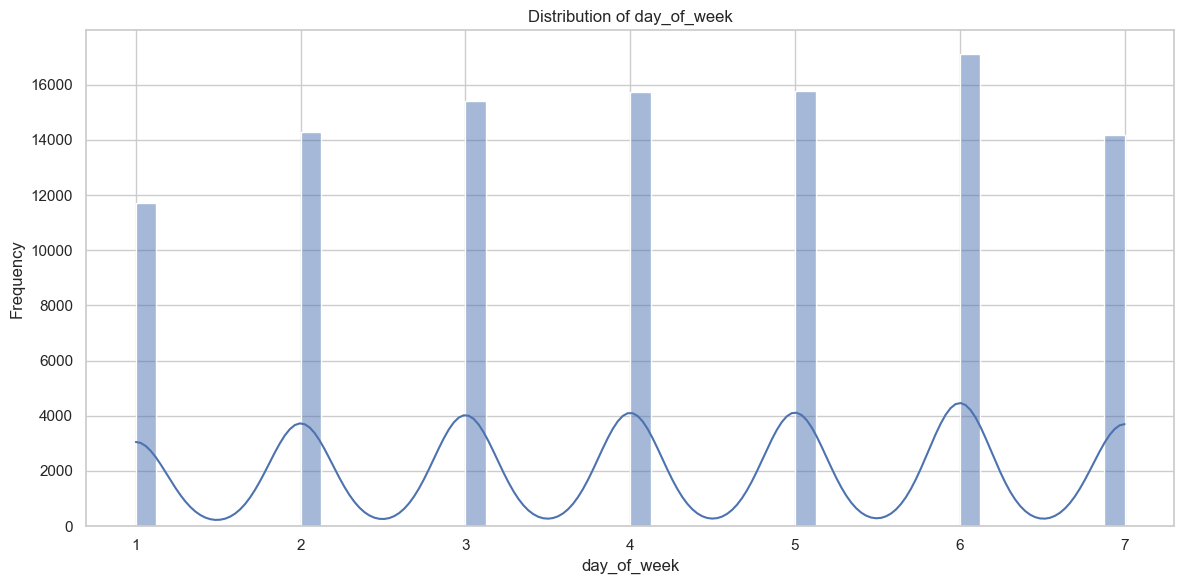

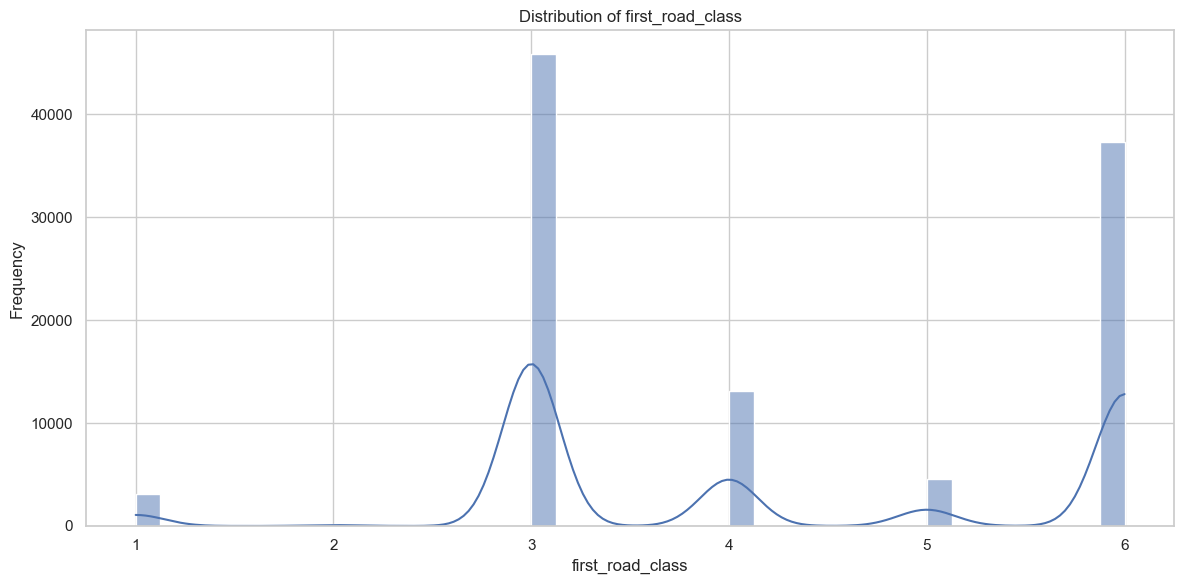

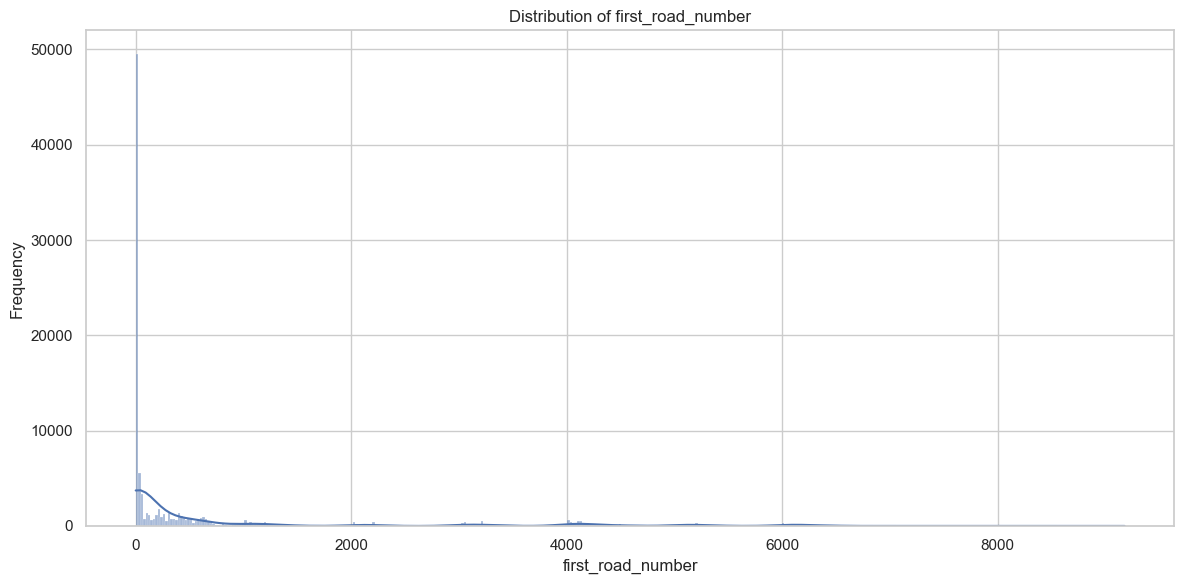

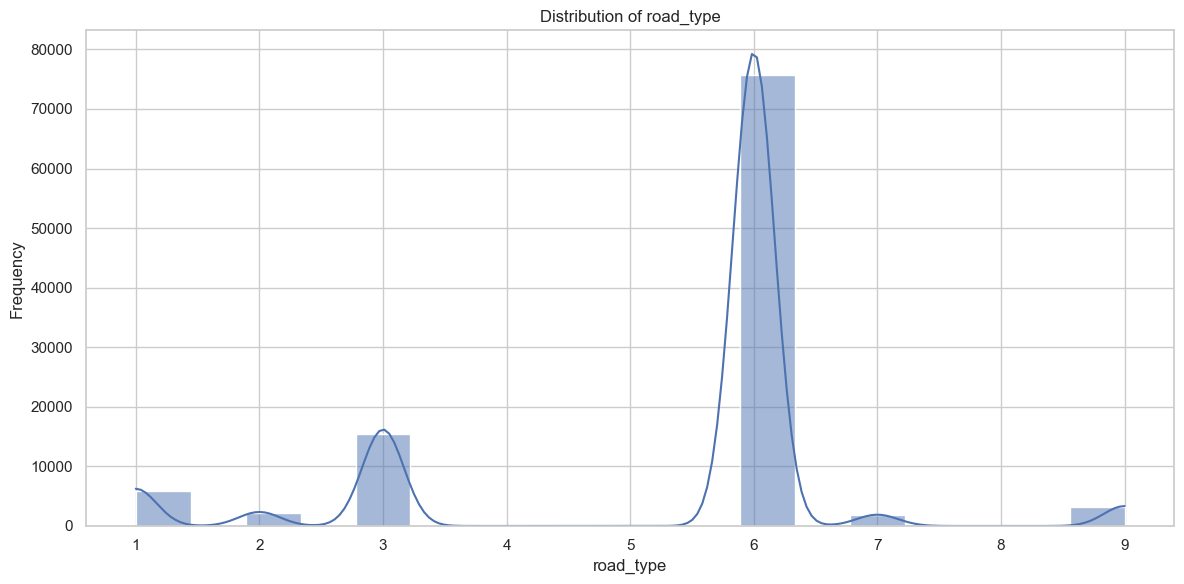

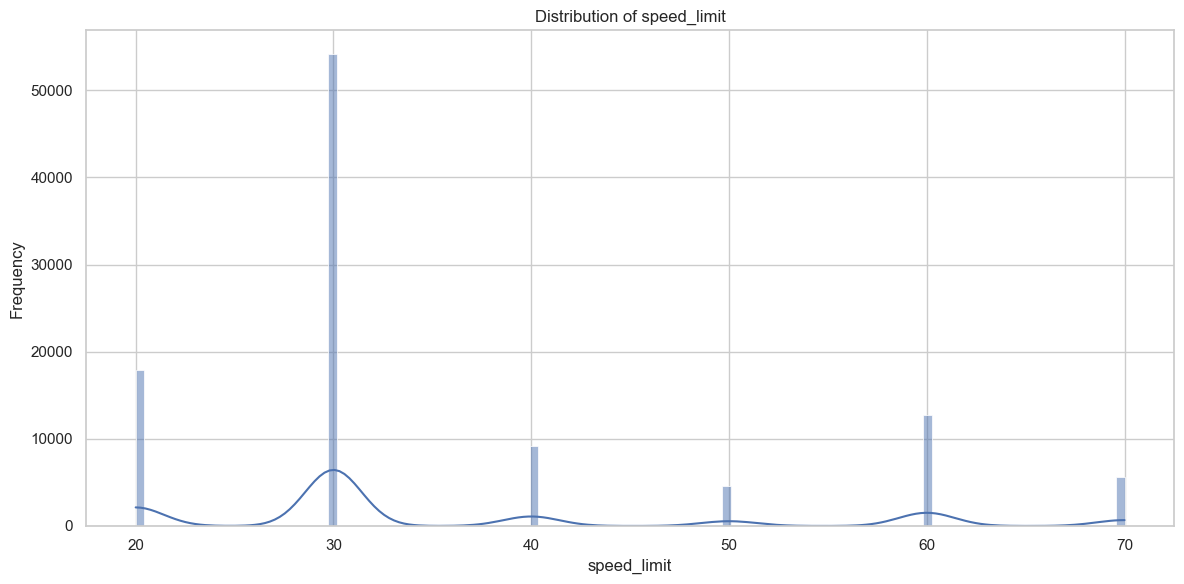

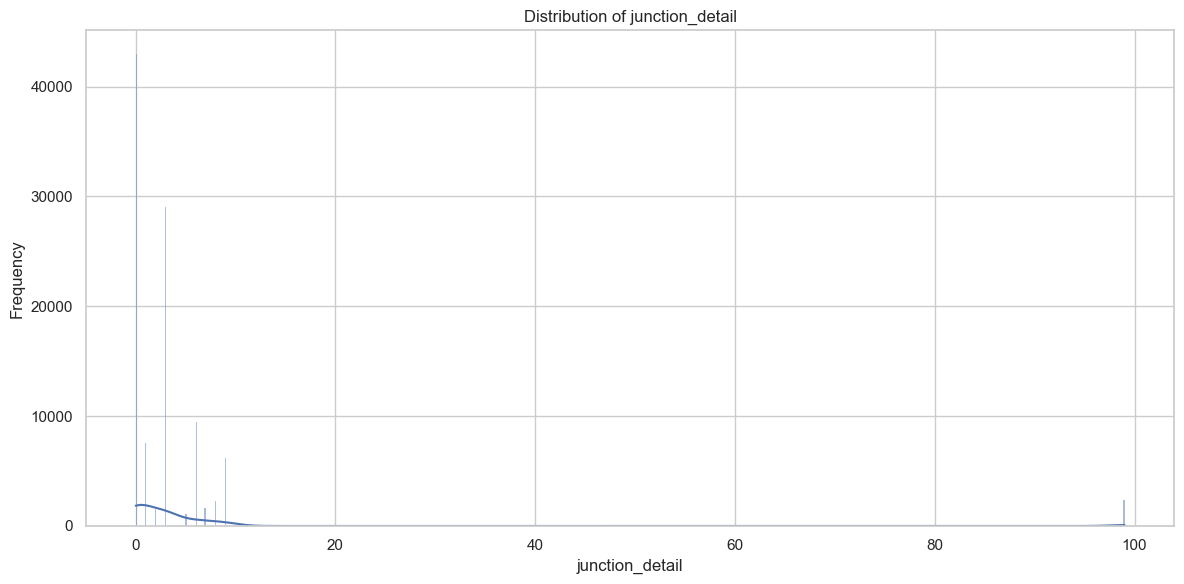

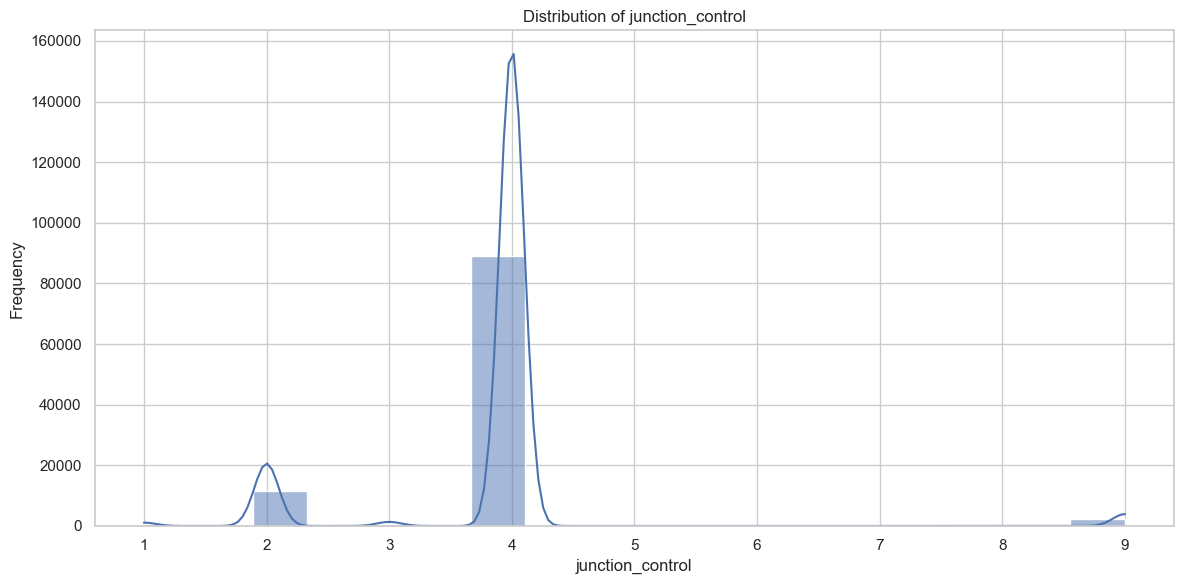

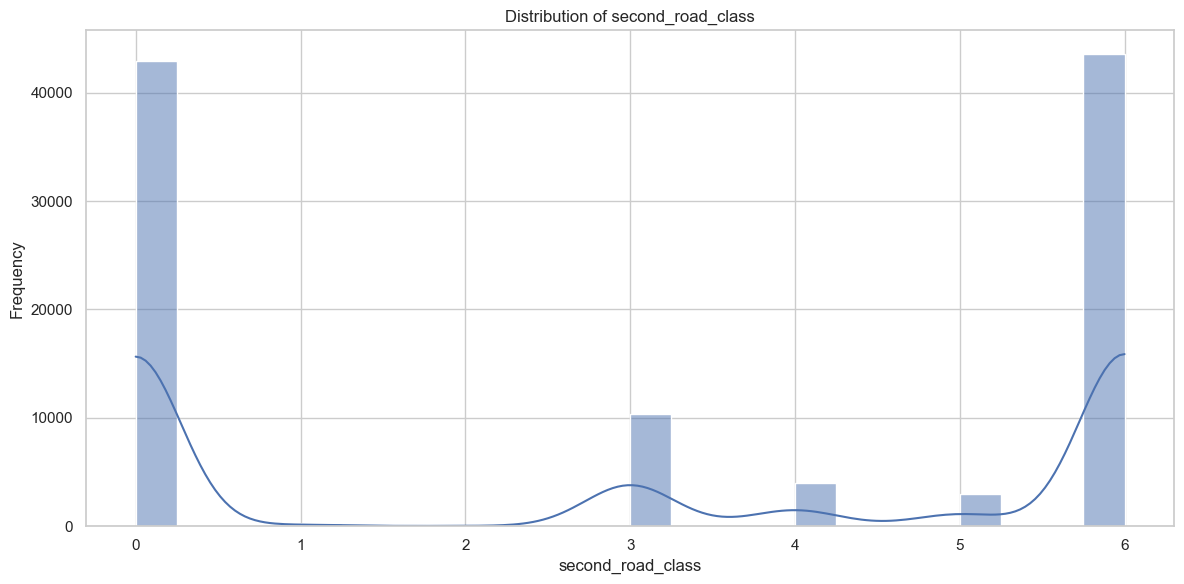

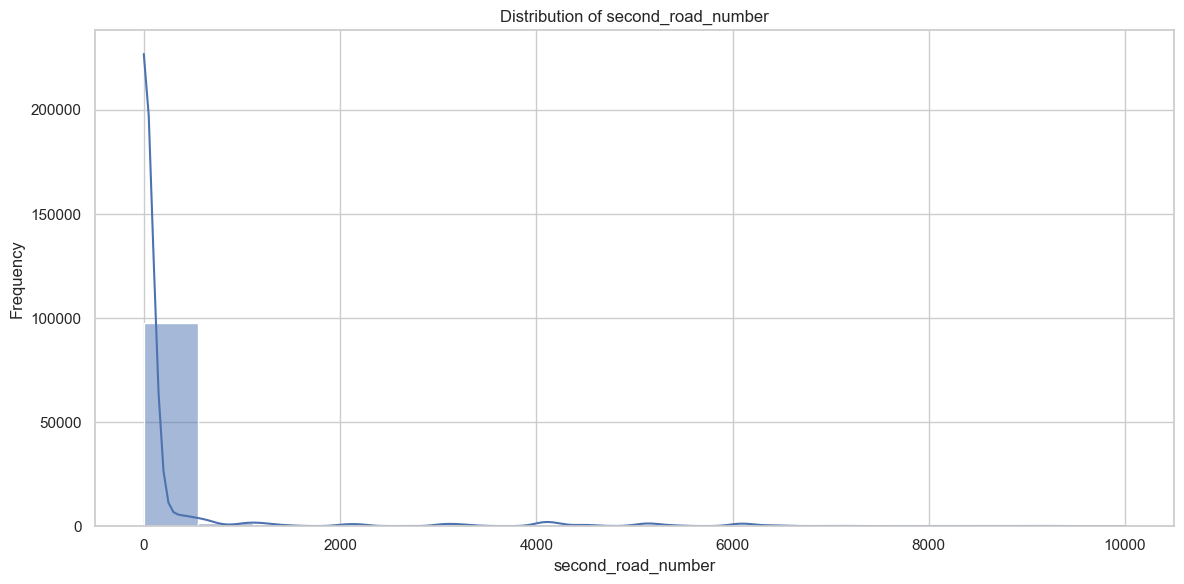

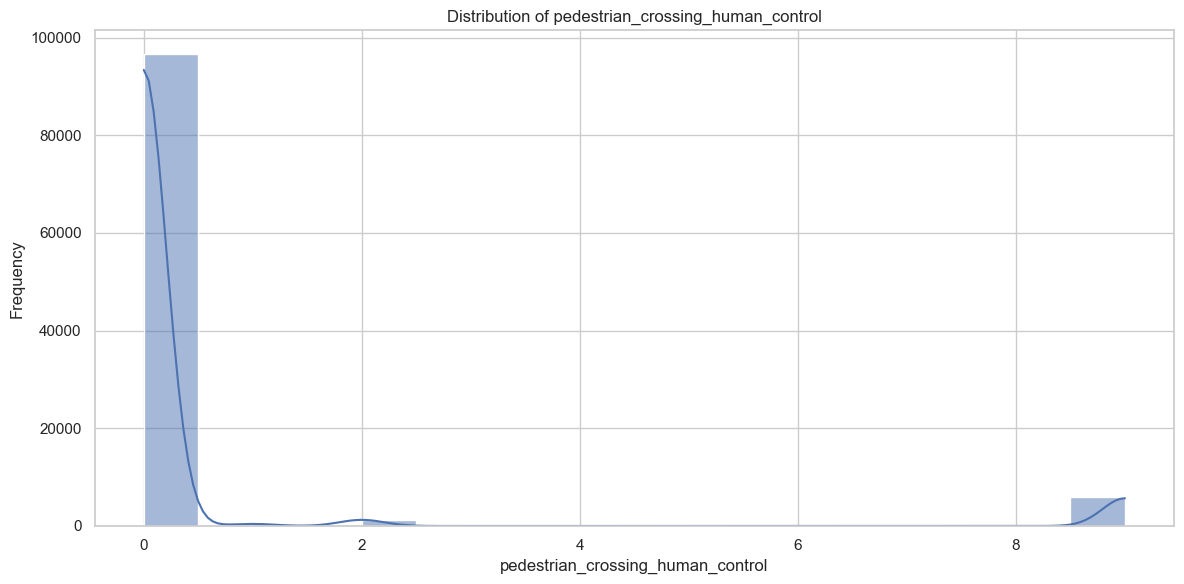

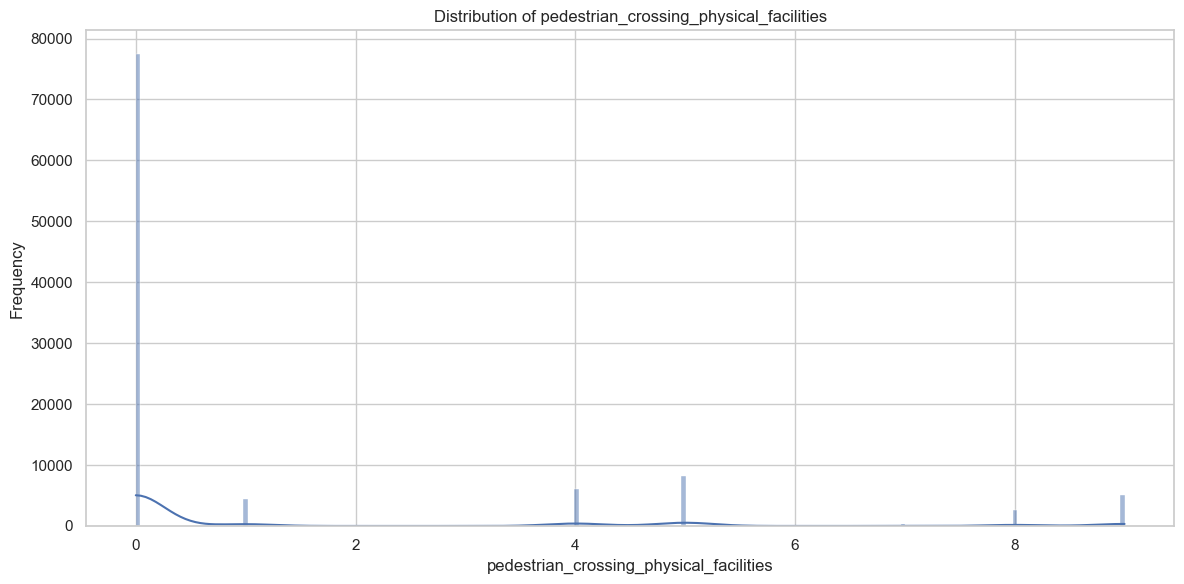

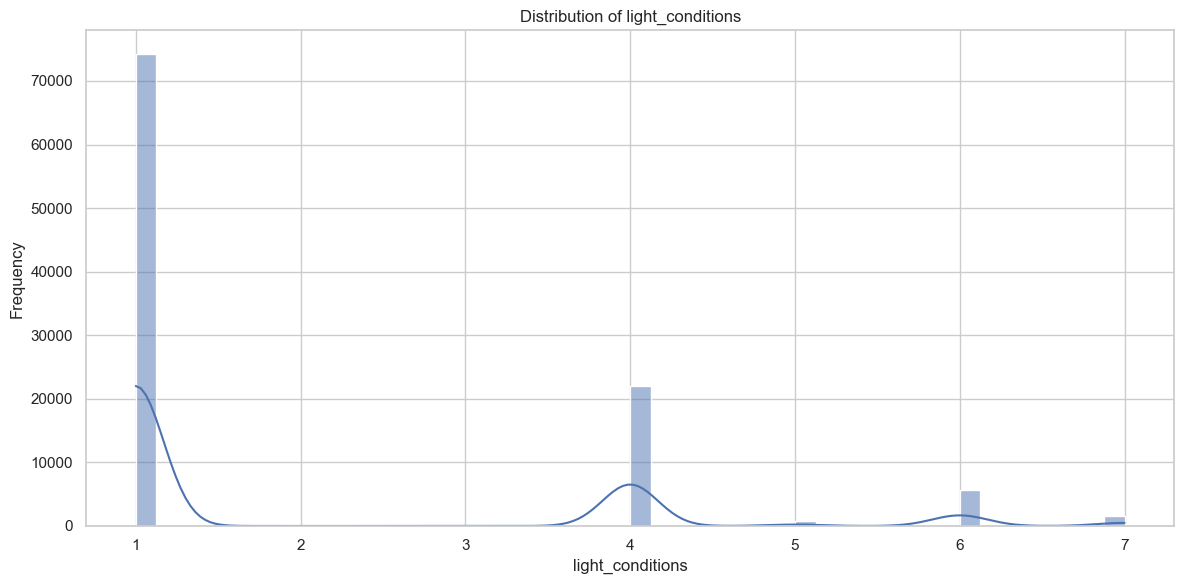

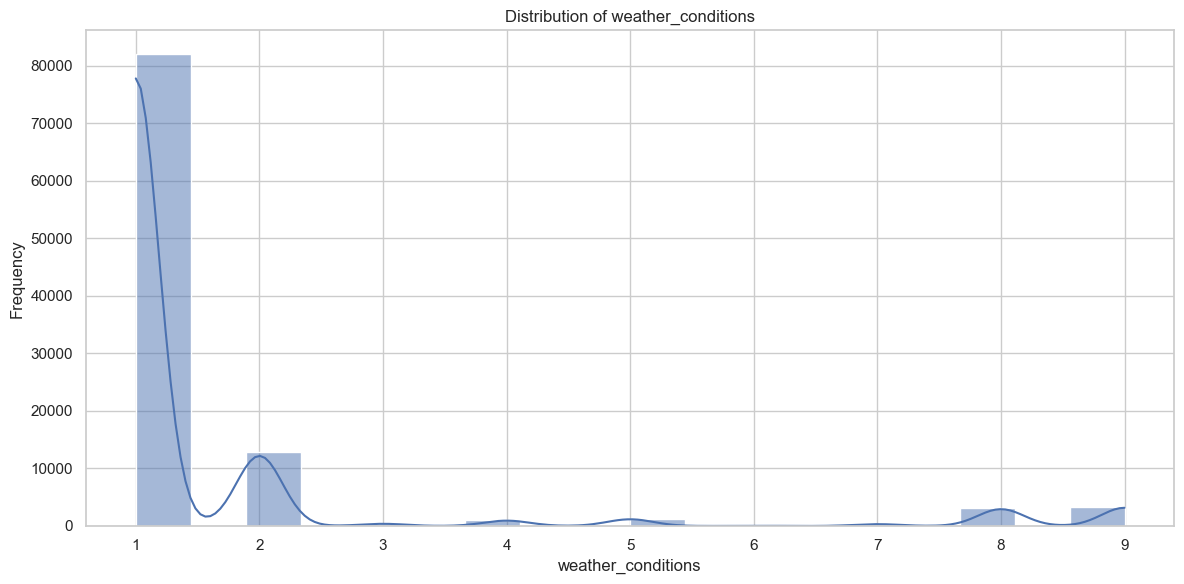

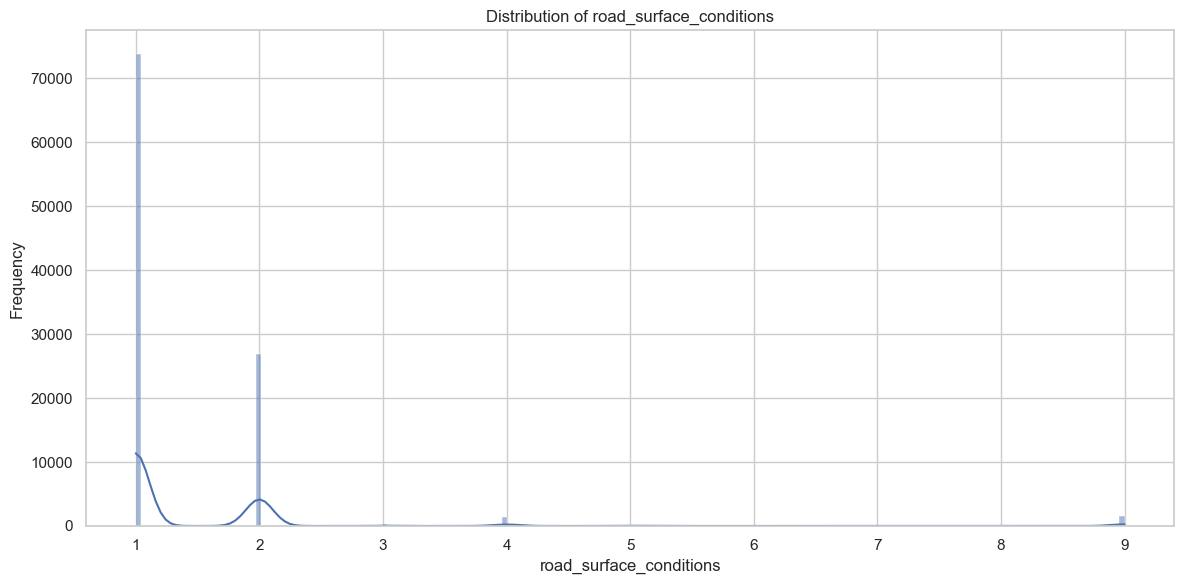

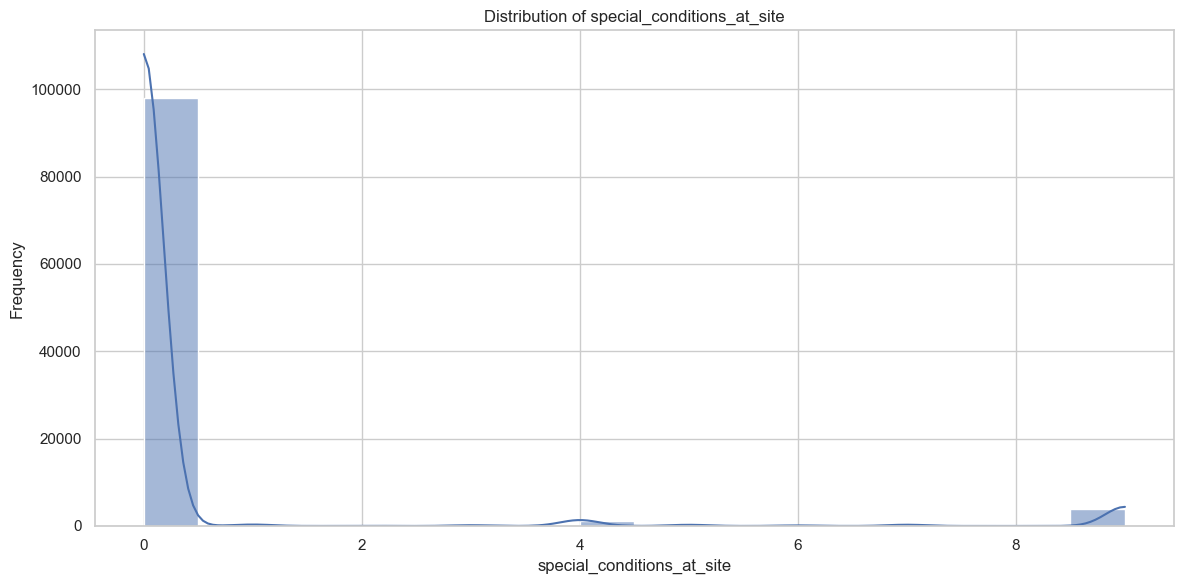

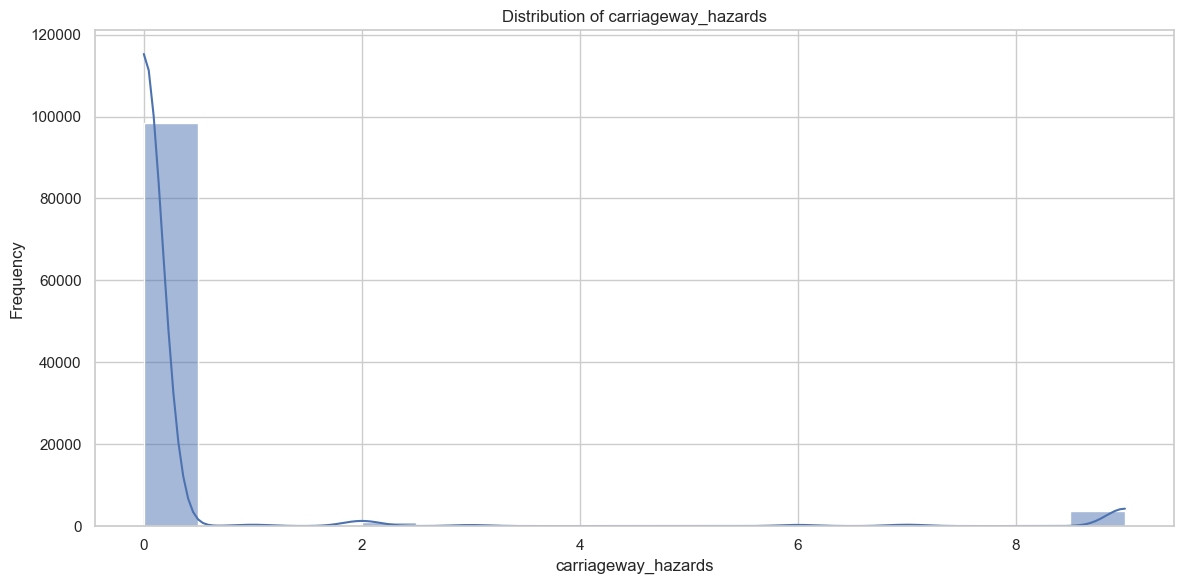

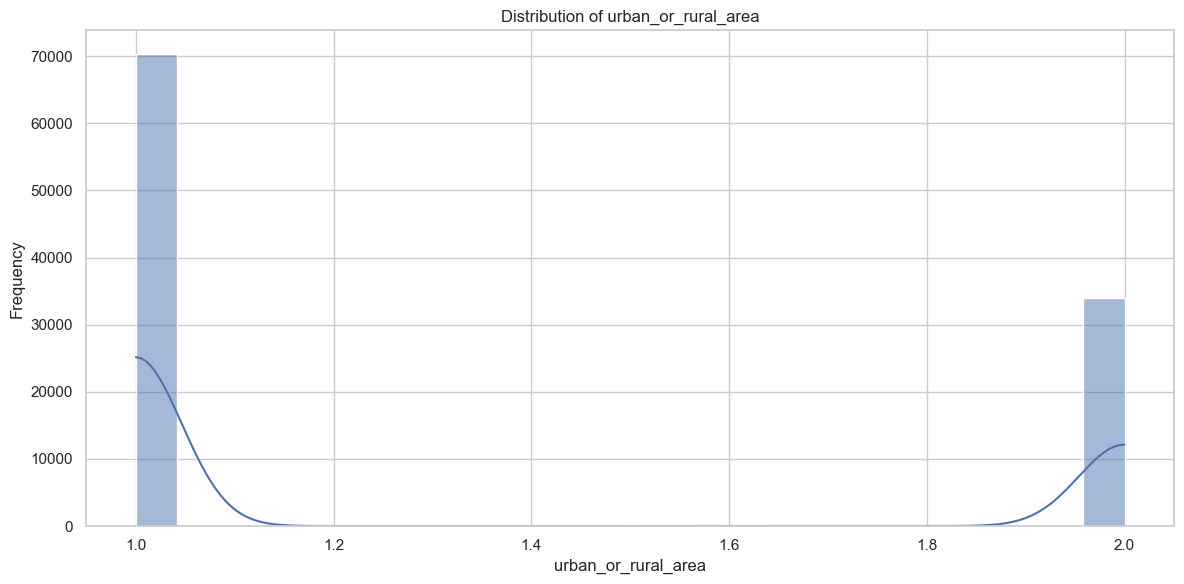

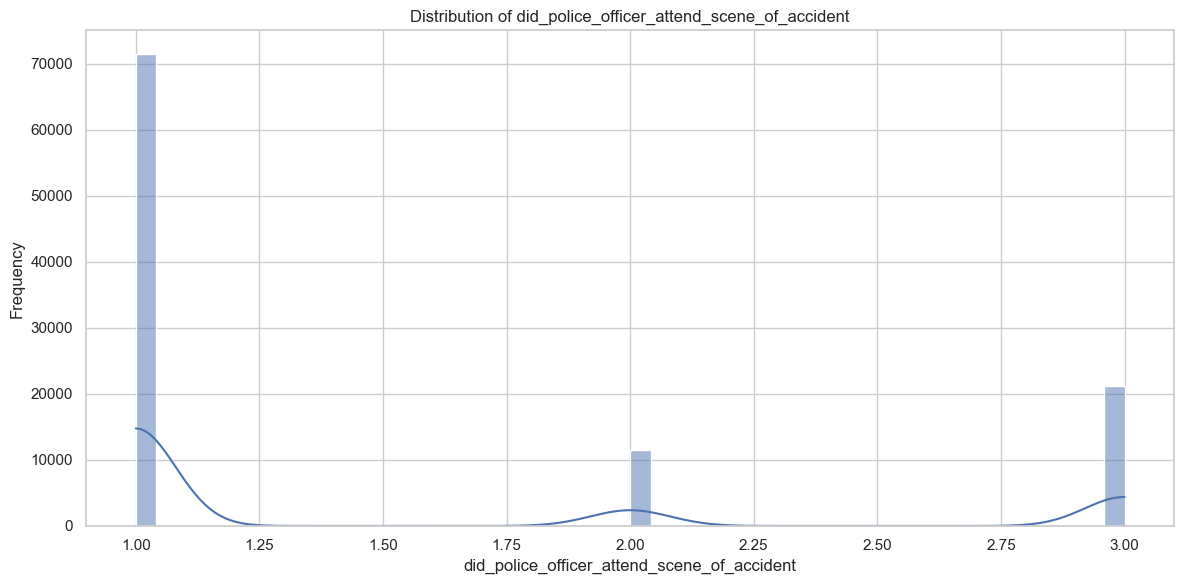

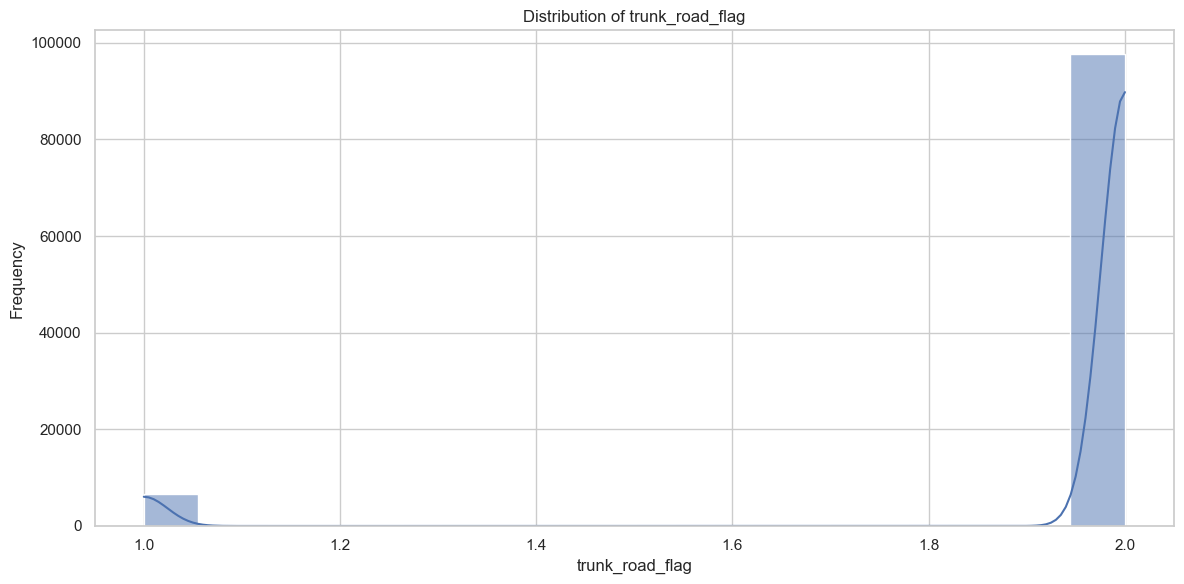

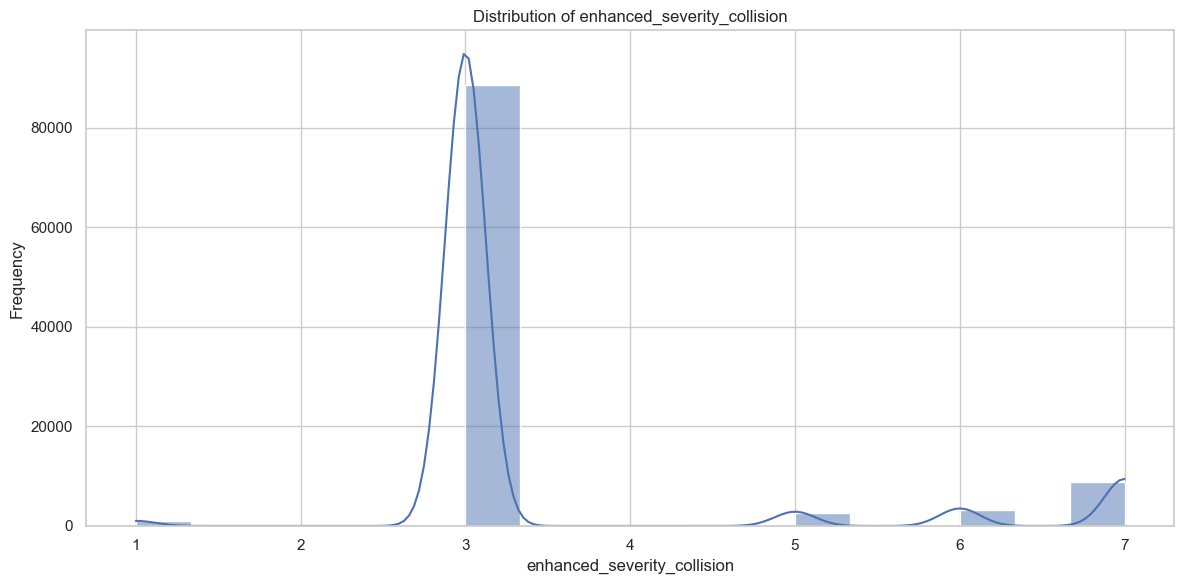

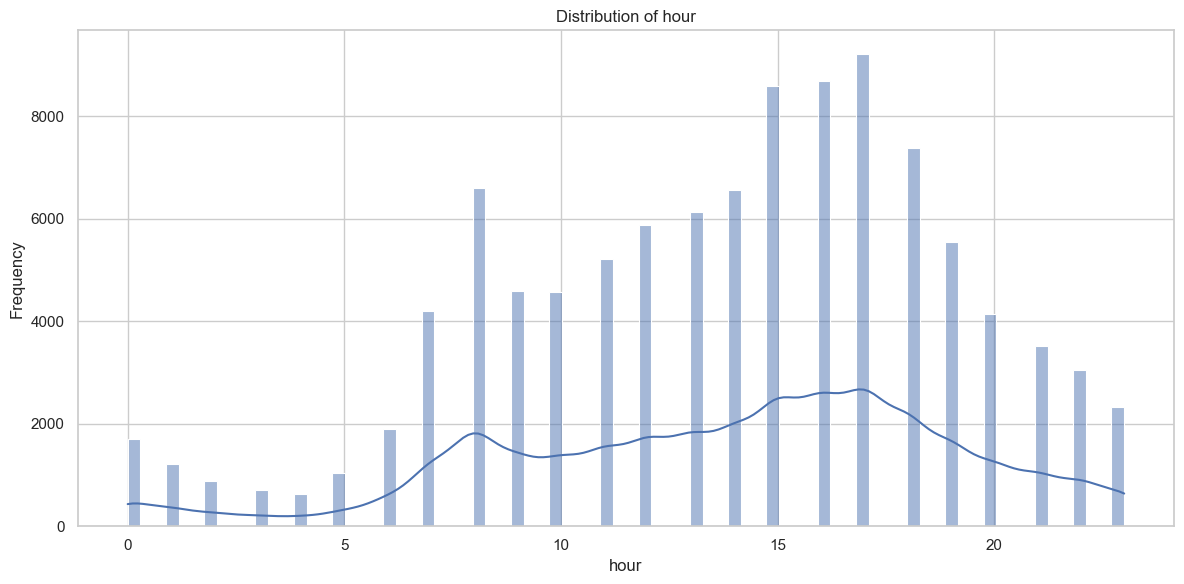

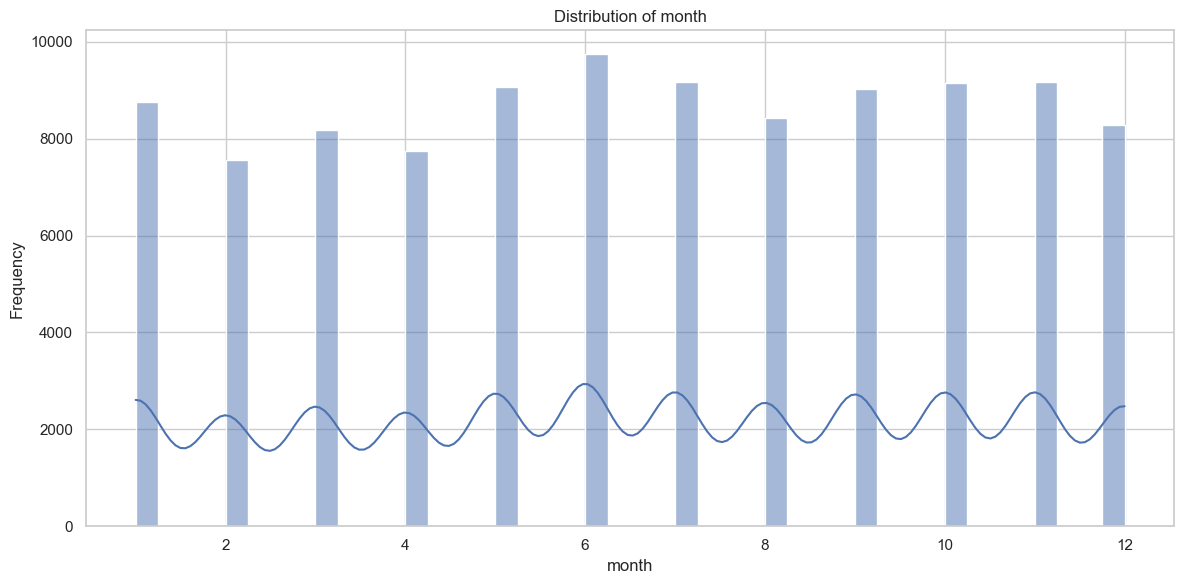

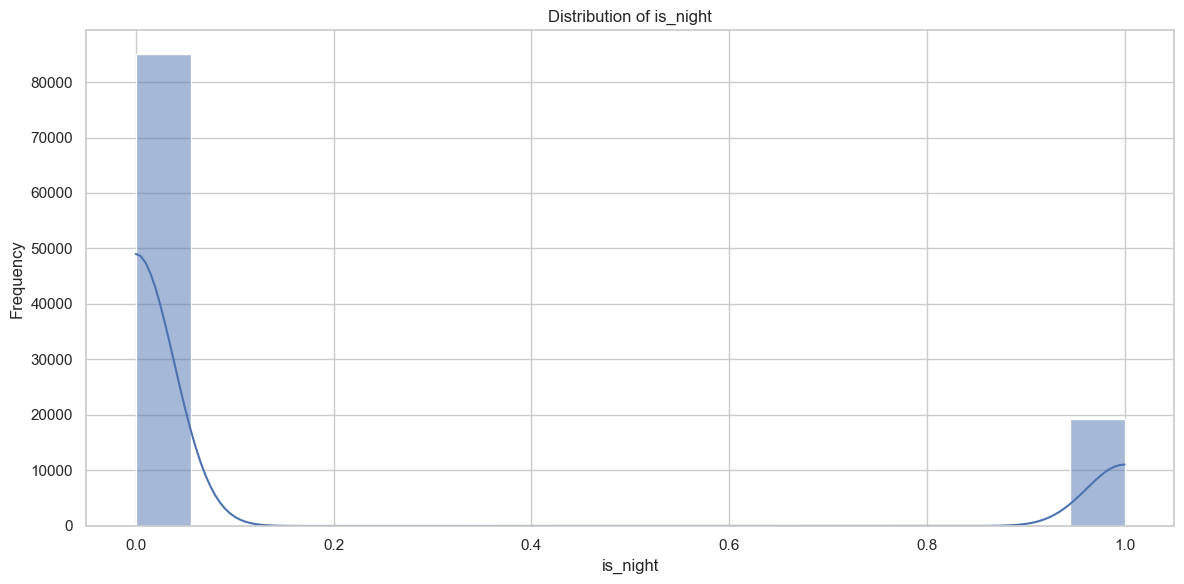

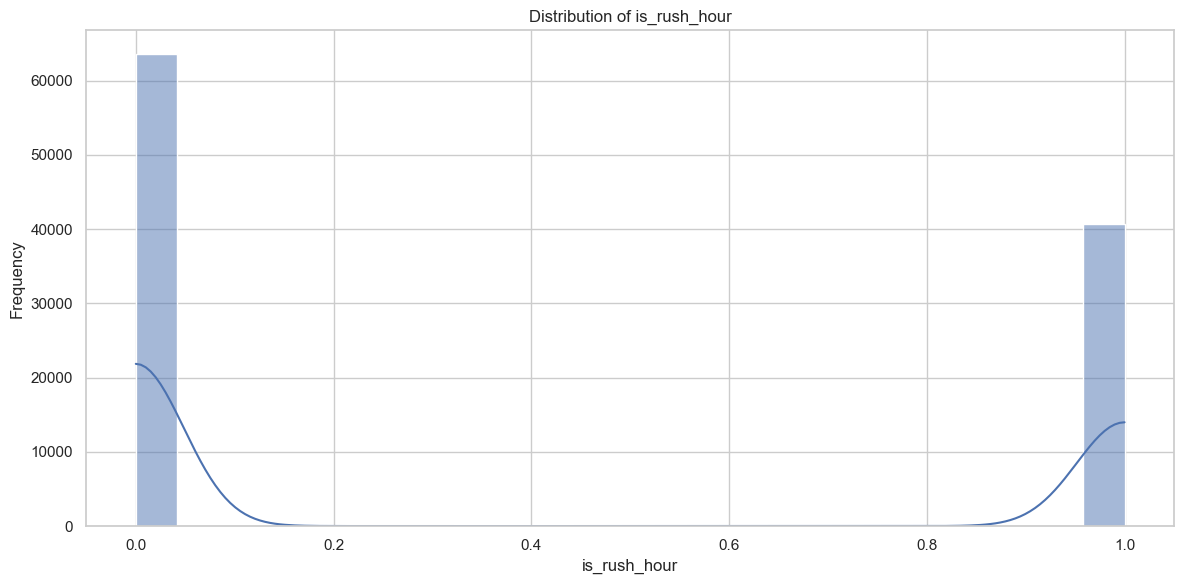

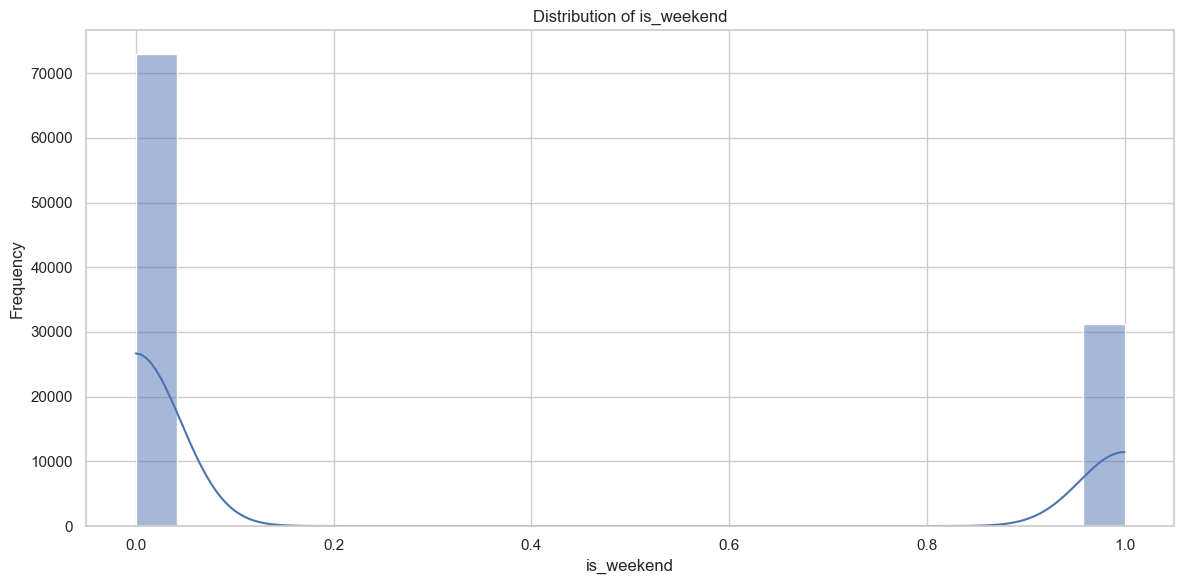

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = df.select_dtypes(include=[np.number]).columns

if RUN_DIAGRAMS:
    for col in numerical_cols:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

## 1B. Categorical Feature Distributions

Understanding how often each category appears helps us evaluate feature quality and relevance. In this section, we:

- Visualise frequency counts for each categorical variable
- Identify dominant categories and potential imbalances
- Limit plots to the top 10 values to retain clarity

This step is important for feature selection and modelling. For example, if a category dominates (e.g. 95% of entries are the same), it may provide little value. On the other hand, consistent class distributions can be valuable predictors of accident severity — such as time of day or weather patterns.

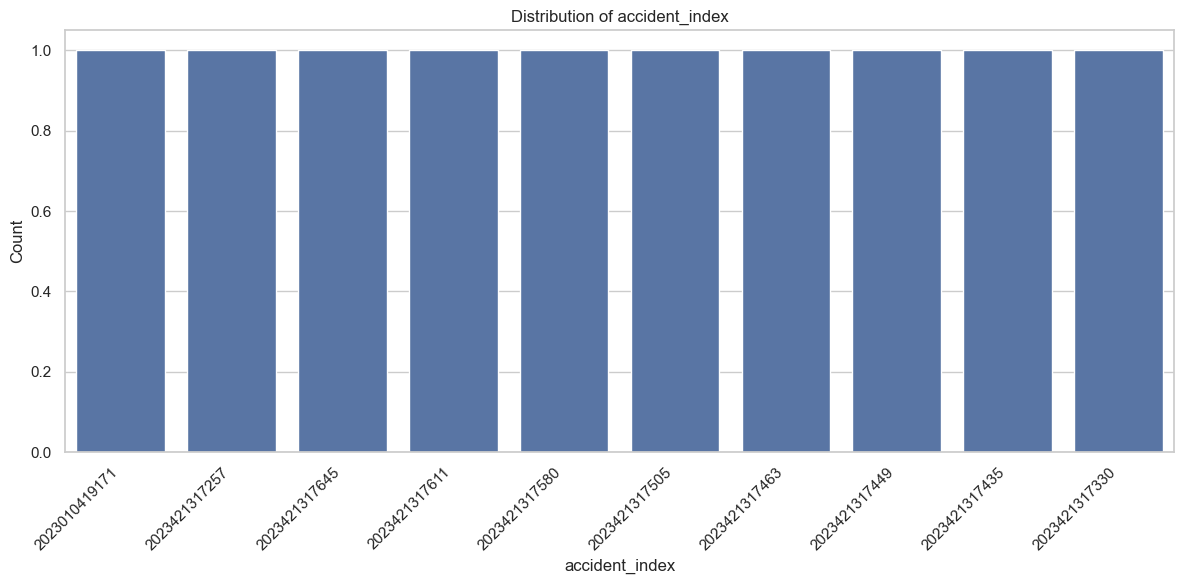

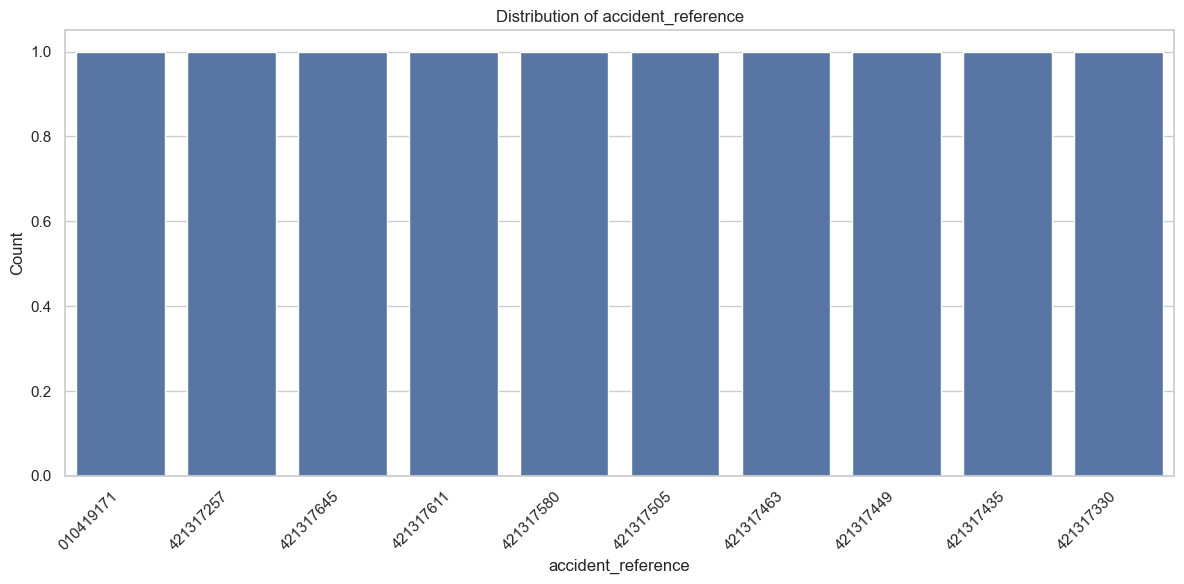

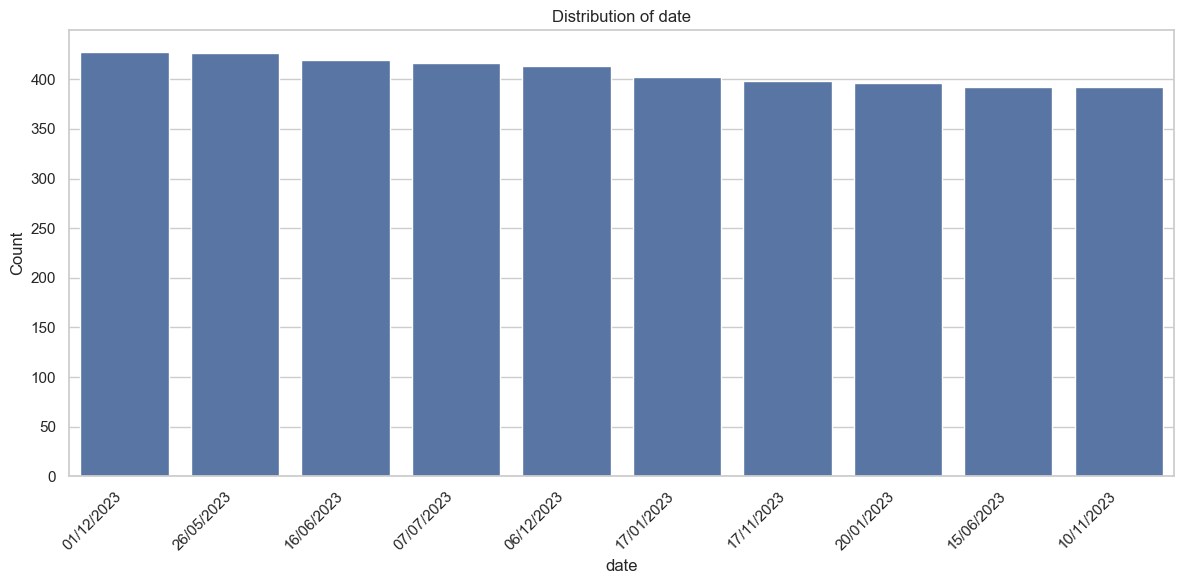

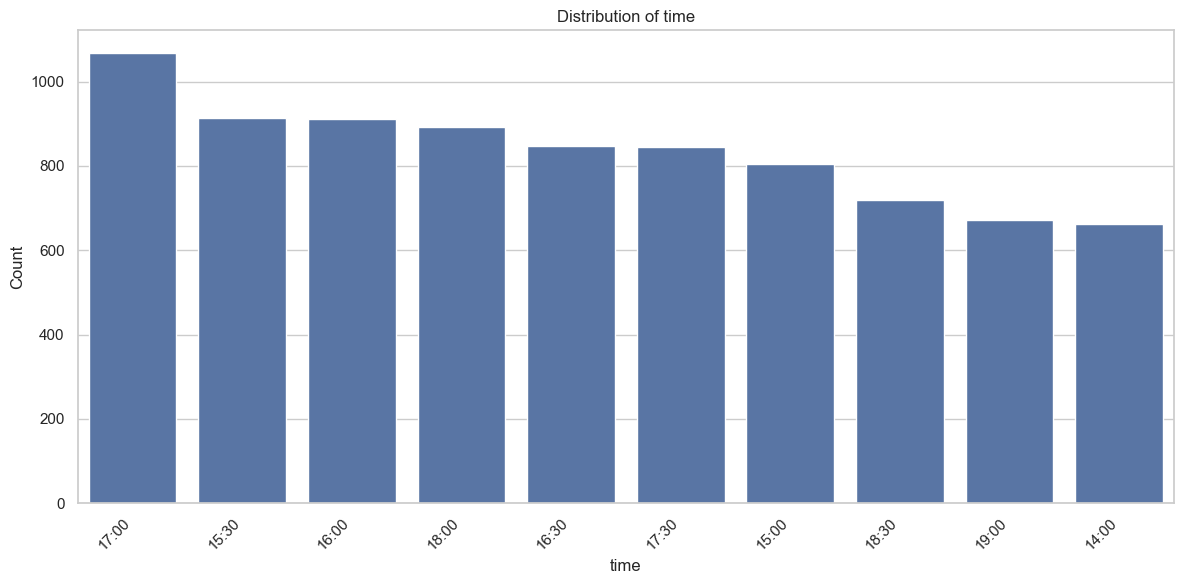

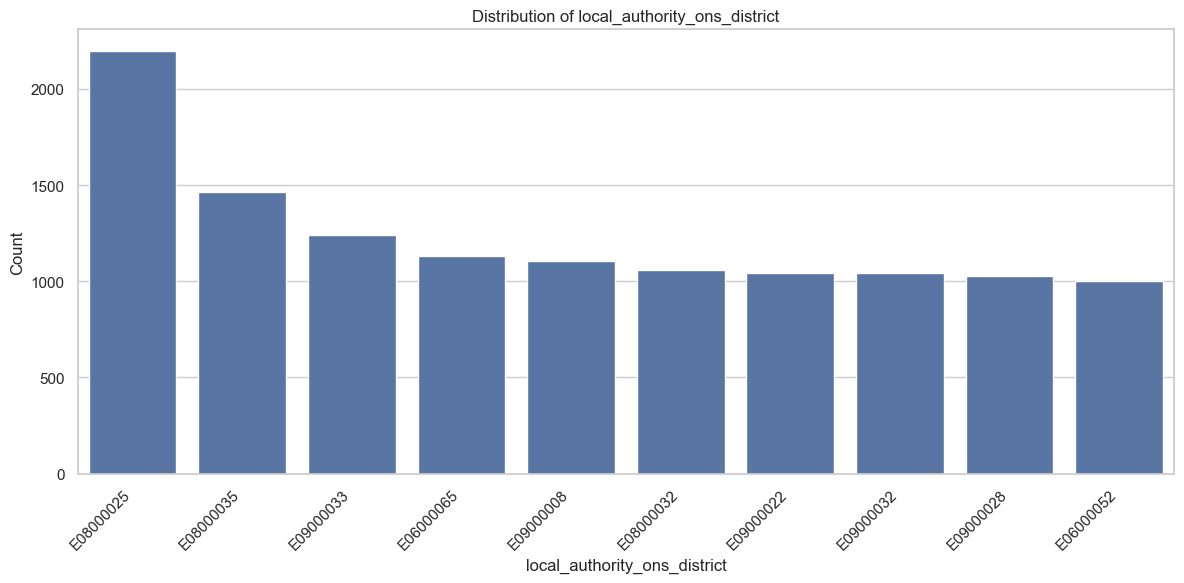

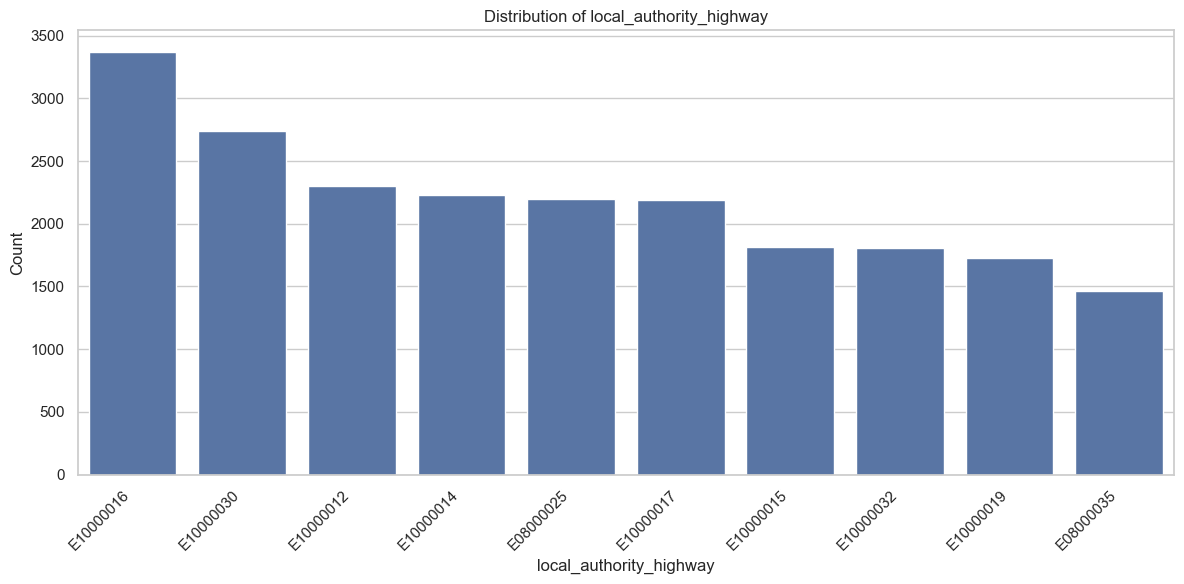

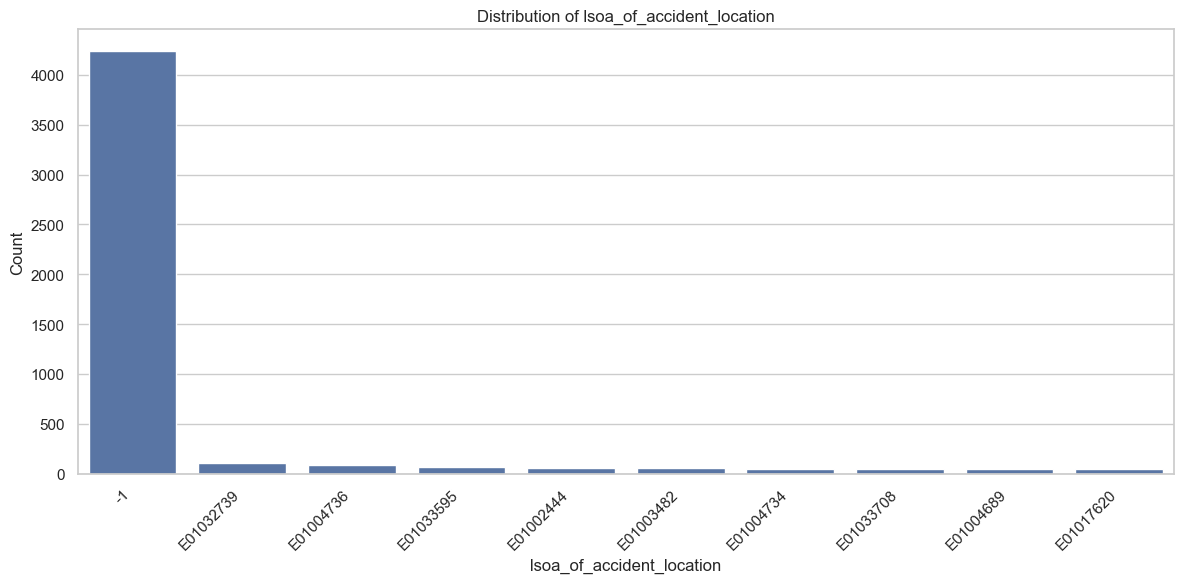

In [43]:
if RUN_DIAGRAMS:
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        plt.figure(figsize=(12, 6))
        value_counts = df[col].value_counts()
        if len(value_counts) > 10:
            value_counts = value_counts.head(10)
        
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 1C. Correlation Matrices

To assess the relationships between numerical features, we calculate correlation matrices using three different methods: Pearson, Spearman, and Kendall.

This analysis helps us:
- Detect multicollinearity that could distort model performance
- Understand linear vs. monotonic relationships between features
- Inform dimensionality reduction or feature elimination strategies

Visualising these matrices highlights pairs of features that are either redundant or highly predictive of each other. This is especially useful when building models like Logistic Regression, which can be sensitive to

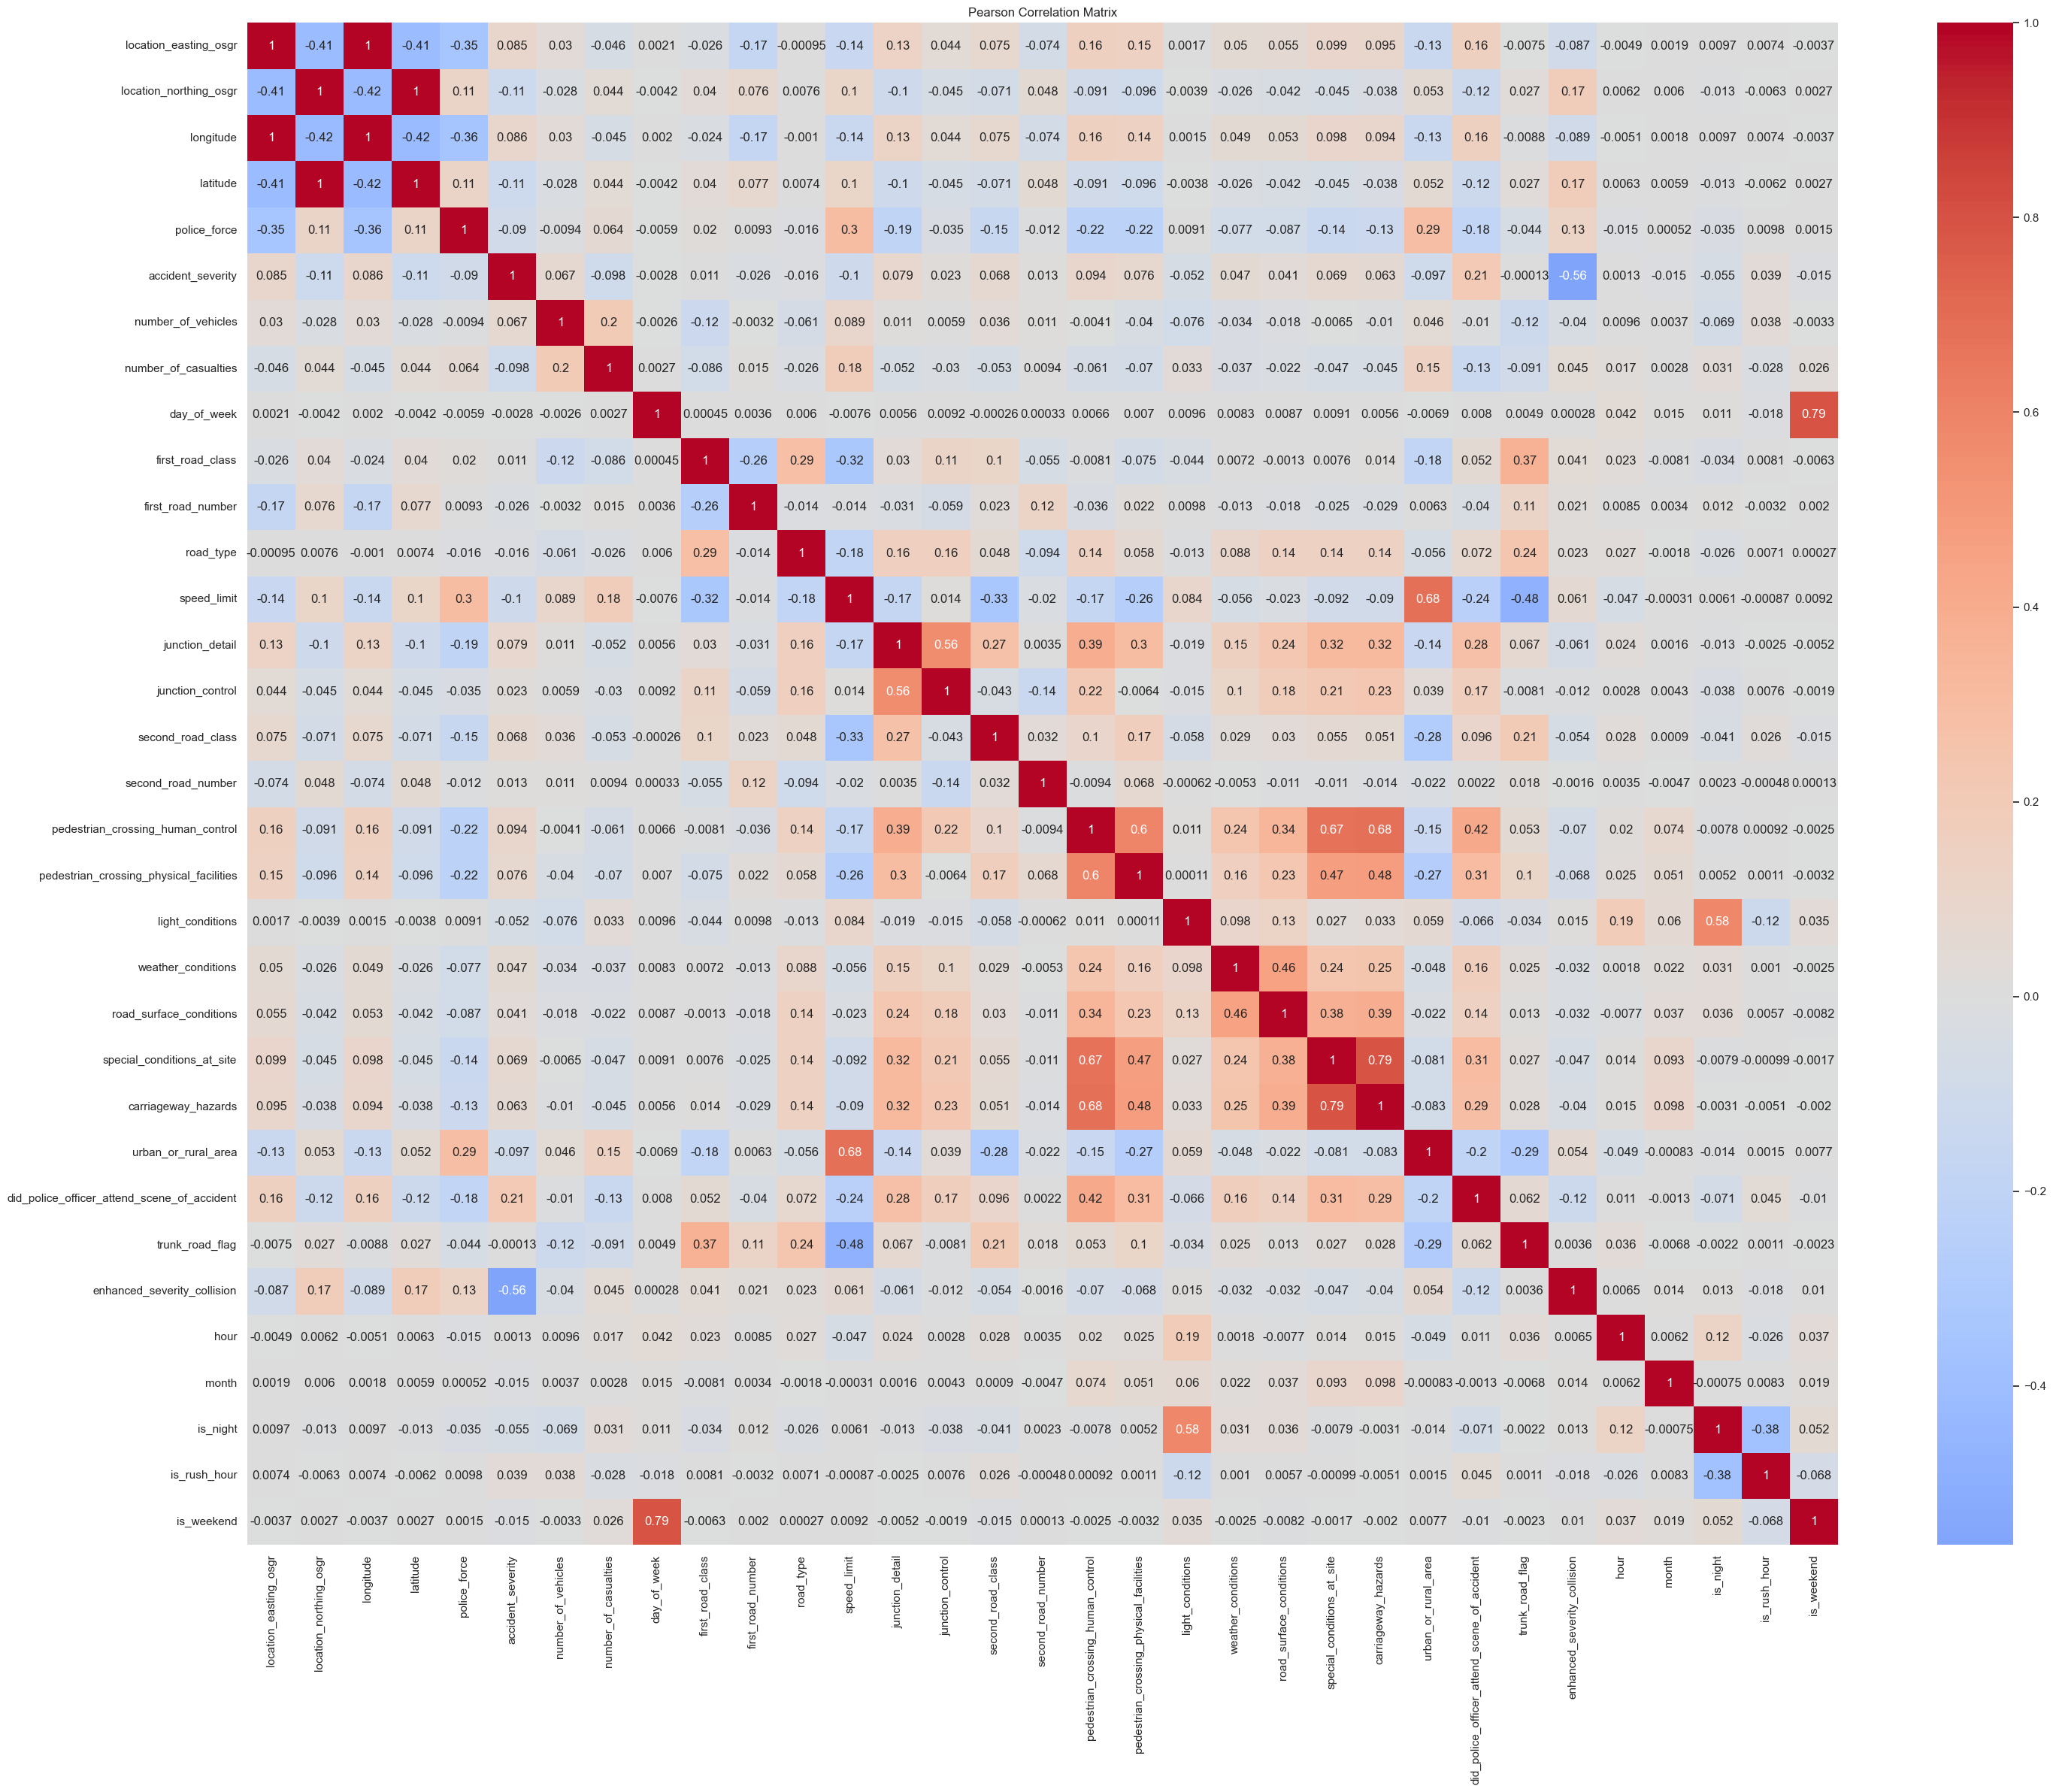

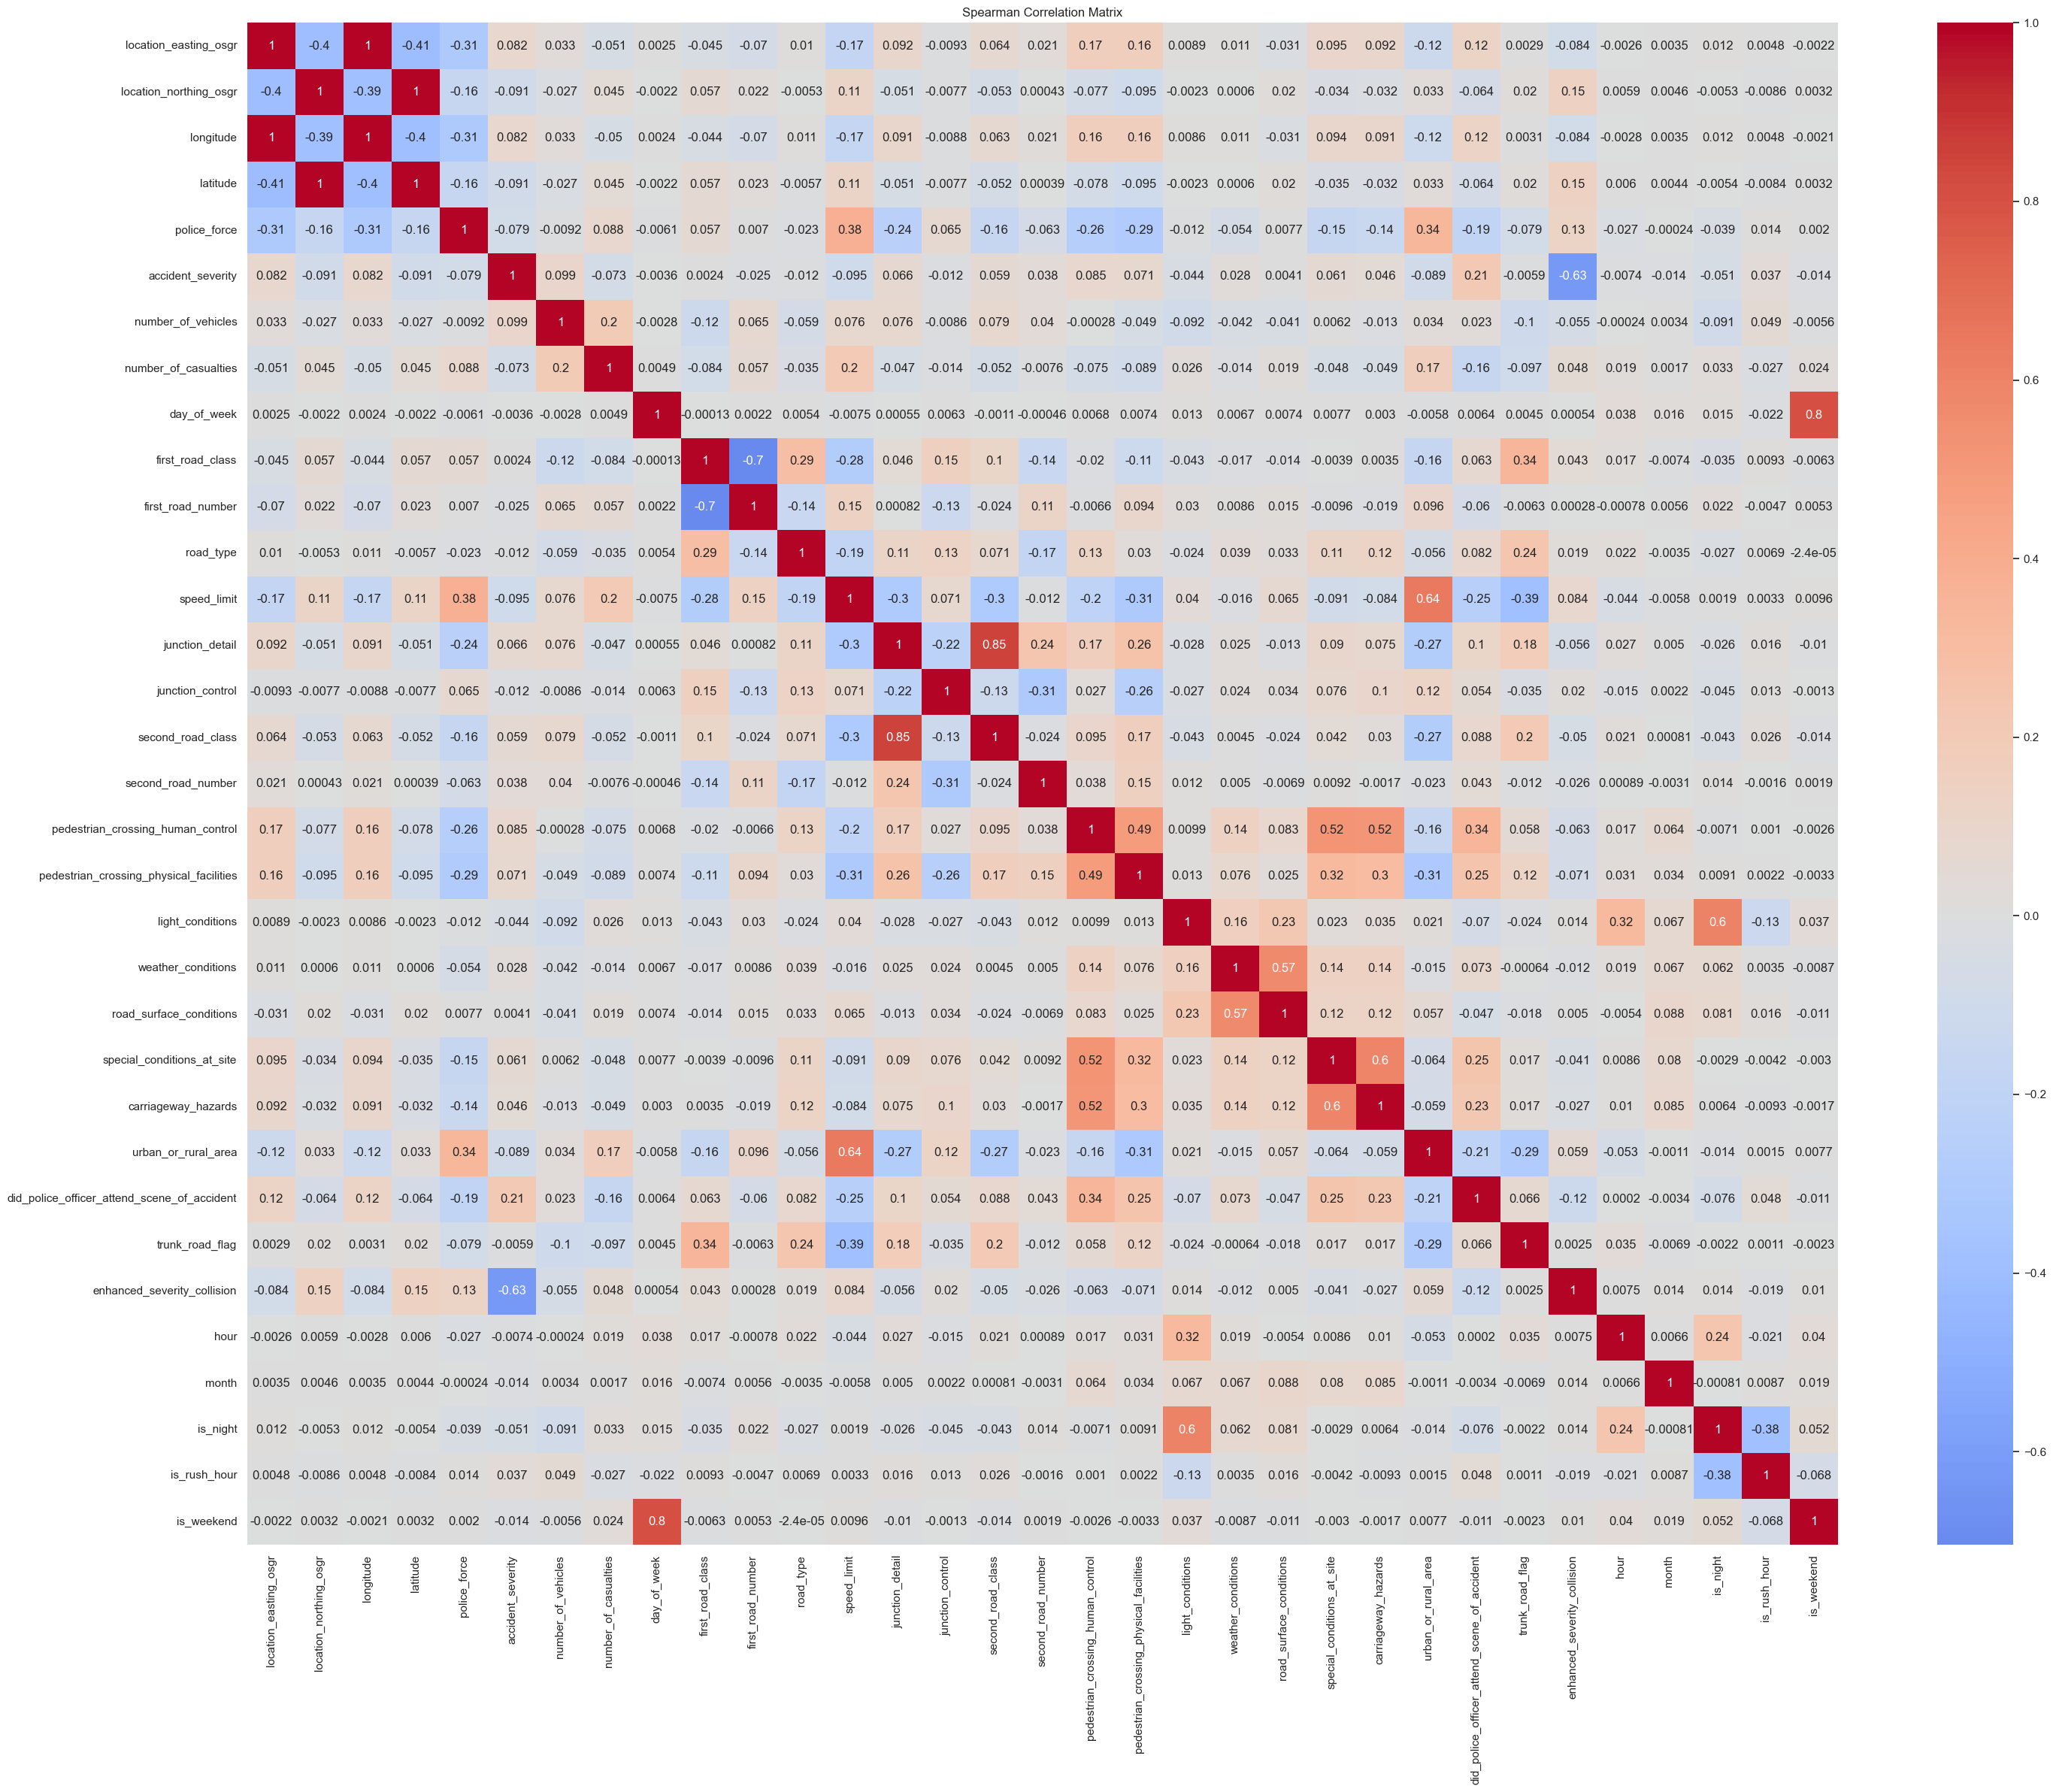

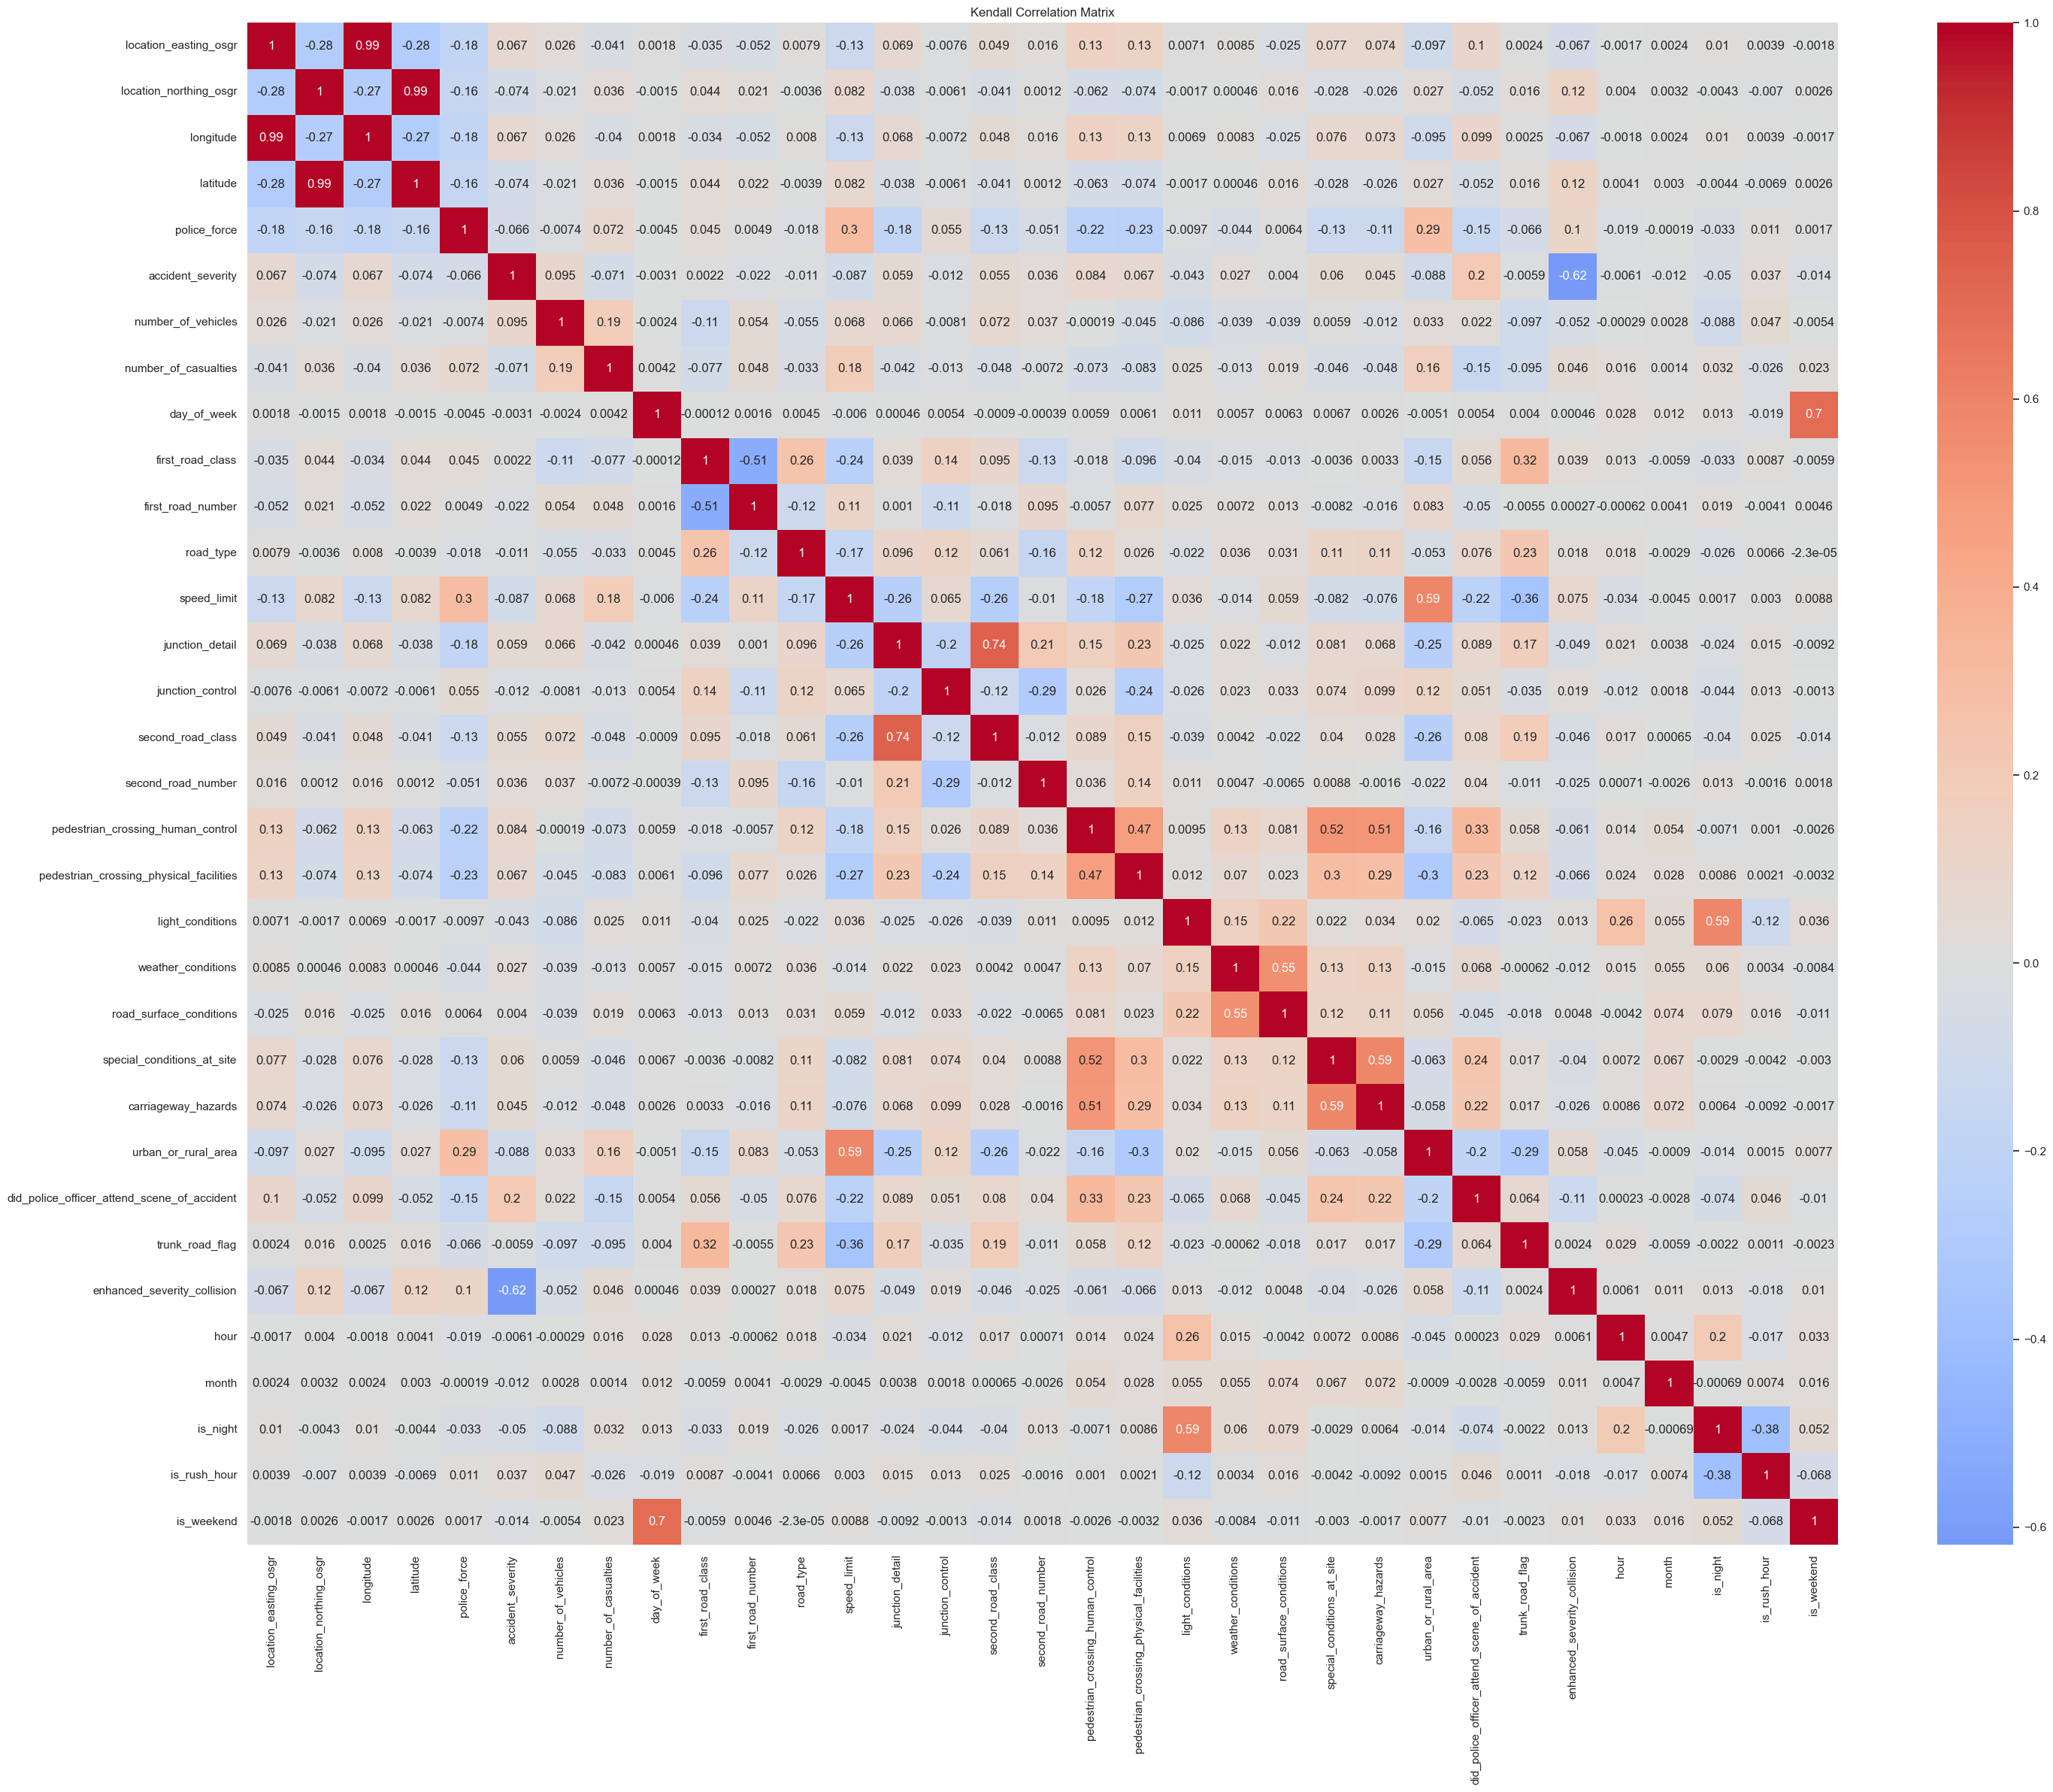

In [127]:
if RUN_DIAGRAMS:
    correlation_methods = ['pearson', 'spearman', 'kendall']

    for method in correlation_methods:
        corr_matrix = df[numerical_cols].corr(method=method)
        plt.figure(figsize=(30, 24))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f'{method.capitalize()} Correlation Matrix')
        plt.tight_layout()
        plt.show() 

## Findings So Far

From our initial inspection, we’ve drawn several important insights about the dataset:

- **Missing Values:** A number of fields use placeholder values like `-1`, especially in environmental and road-related fields (e.g. `junction_control`, `trunk_road_flag`). These need cleaning and imputation before analysis.
- **Redundant Columns:** Some features have no variability (e.g. `accident_year`) or extremely high cardinality (e.g. `accident_index`), suggesting they carry little predictive value.
- **Potential Data Quality Issues:** A small number of rows are missing key geolocation data (e.g. `latitude`, `longitude`), which would interfere with geospatial analysis.
- **Temporal and Regional Variation:** Features such as `date`, `time`, and `local_authority_*` show enough diversity to warrant engineering into more meaningful insights later.
- **Imbalanced Classes:** The target variable `accident_severity` is highly skewed:
  - Slight: ~76%
  - Serious: ~22%
  - Fatal: ~1.5%
  This imbalance is likely to affect model performance, particularly in detecting rare but critical fatal accidents.

Together, these findings shape our cleaning and feature engineering strategies in the next stage.

## 2A. Data Cleaning

To ensure our dataset is reliable and suitable for modelling, we apply several targeted cleaning steps:

- **Location Filtering:** We remove 12 rows that lack essential geospatial coordinates (`latitude`, `longitude`, etc.), as these are needed for future spatial analyses.
- **Low-Value Columns:** Columns with no variability (e.g. `accident_year`) or high-cardinality identifiers (e.g. `accident_index`) are dropped, as they offer little modelling value.
- **Placeholder Handling:** Several numeric fields use `-1` to represent missing or unknown values. We replace these with proper `NaN` values so they can be detected and imputed correctly.
- **String Normalisation:** Categorical string fields are trimmed and converted to lowercase to reduce accidental category fragmentation (e.g. `'Oxford '` vs `'oxford'`).
- **Missing Value Imputation:** We use median imputation for numeric features to preserve robustness against outliers while ensuring no data is lost due to missing values.

These steps standardise and prepare the dataset for feature engineering and modelling, addressing quality concerns identified in our earlier inspection.

In [45]:
# Remove rows with missing essential location information
location_cols = ['location_easting_osgr', 'location_northing_osgr', 'latitude', 'longitude']
initial_rows = len(df)
df = df.dropna(subset=location_cols)
rows_removed = initial_rows - len(df)


# Remove low-value columns except latitude and longitude (only)
low_value_data = df[list(low_value_cols)]

low_value_cols = [col for col in low_value_cols if col not in ['latitude', 'longitude']]

df = df.drop(columns=list(low_value_cols))



print(f"Rows removed due to missing location data: {rows_removed}")
print(f"Remaining rows after location data cleaning: {len(df)}")

# Replace -1 with NaN for numeric columns (e.g., placeholder values)
numeric_cols = df.select_dtypes(include=[np.number]).columns
replacements = {}
for col in numeric_cols:
    count = (df[col] == -1).sum()
    if count > 0:
        df[col] = df[col].replace(-1, np.nan)
        replacements[col] = count

print("\nColumns where -1 values were replaced with NaN:")
for col, count in replacements.items():
    print(f"{col}: {count} replacements")

# Standardise string columns: lowercase and strip whitespace
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.strip().str.lower()

print("\nUnique value counts in string columns after cleaning:")
for col in object_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Show top 10 most frequent values in each categorical column
print("\nTop 10 most frequent values for each categorical column:")
for col in object_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))

# Remove low-value columns




Rows removed due to missing location data: 12
Remaining rows after location data cleaning: 104246

Columns where -1 values were replaced with NaN:
junction_detail: 1 replacements
junction_control: 43790 replacements
second_road_class: 84 replacements
second_road_number: 43041 replacements
pedestrian_crossing_human_control: 2789 replacements
pedestrian_crossing_physical_facilities: 2783 replacements
road_surface_conditions: 1064 replacements
special_conditions_at_site: 3116 replacements
carriageway_hazards: 3127 replacements
trunk_road_flag: 7482 replacements
enhanced_severity_collision: 48229 replacements

Unique value counts in string columns after cleaning:
date: 365 unique values
time: 1440 unique values
local_authority_ons_district: 351 unique values
local_authority_highway: 208 unique values
lsoa_of_accident_location: 26838 unique values

Top 10 most frequent values for each categorical column:

date:
date
01/12/2023    428
26/05/2023    427
16/06/2023    419
07/07/2023    416
06/

In [46]:
# get all columns NaN
# Check for NaN values in all columns
nan_counts = df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_counts[nan_counts > 0].sort_values(ascending=False))

# Impute missing values
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    imputer = SimpleImputer(strategy='median')
    df[col] = imputer.fit_transform(df[[col]])


Number of NaN values in each column:
enhanced_severity_collision                48229
junction_control                           43790
second_road_number                         43041
trunk_road_flag                             7482
carriageway_hazards                         3127
special_conditions_at_site                  3116
pedestrian_crossing_human_control           2789
pedestrian_crossing_physical_facilities     2783
road_surface_conditions                     1064
second_road_class                             84
junction_detail                                1
dtype: int64


In [47]:

# Show missing values after imputation

print("\nMissing values in features after imputation:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0].sort_values(ascending=False))


Missing values in features after imputation:
Series([], dtype: int64)


## 2B. Feature Engineering for Risk Modelling

With a clean dataset in place, we enrich it by deriving new features aimed at capturing patterns linked to accident severity. Our goal is to inject contextual knowledge — particularly around time and environment — into the dataset.

Specifically, we:

- **Extract Temporal Features:** From the `date` and `time` fields, we extract the `hour` and `month` to study trends across different times of day and seasons.
- **Define Risk Windows:** We create binary indicators for:
  - `is_night` — late-night hours (8 PM–5 AM), when visibility is reduced
  - `is_rush_hour` — typical commuting periods (7–9 AM and 4–6 PM)
  - `is_weekend` — Saturday and Sunday, when traffic patterns differ
- **Combine Environmental Conditions:** We construct a new feature `road_weather_combo` by merging `road_surface_conditions` and `weather_conditions`. This captures how combined adverse conditions may elevate accident risk.

These features are designed to expose nuanced relationships between external conditions and severity, offering the model more meaningful signals to learn from.

In [48]:

# 1. Extract temporal features
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time
df['hour'] = pd.to_datetime(df['time'].astype(str)).dt.hour
df['month'] = df['date'].dt.month
# day_of_week is already present in the dataset

# 2. Create binary features
df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 20 or x <= 5) else 0)
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if ((x >= 7 and x <= 9) or (x >= 16 and x <= 18)) else 0)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)

# 3. Create road_weather_combo (improved version)
# First, drop rows where either condition is missing
df = df.dropna(subset=['road_surface_conditions', 'weather_conditions'])
df['road_weather_combo'] = df['road_surface_conditions'].astype(str) + '_' + df['weather_conditions'].astype(str)

# Show class balance of accident severity (UK DfT Classification)
print("\nClass balance of accident_severity (UK DfT Classification):")
severity_counts = df['accident_severity'].value_counts().sort_index()
severity_labels = {
    1: "Fatal",
    2: "Serious",
    3: "Slight"
}
print("\nAccident severity counts:")
for severity, count in severity_counts.items():
    print(f"{severity_labels[severity]}: {count:,}")
print("\nAccident severity percentages:")
total_count = len(df)
for severity, count in severity_counts.items():
    percentage = round((count / total_count * 100), 2)
    print(f"{severity_labels[severity]}: {percentage}%")


Class balance of accident_severity (UK DfT Classification):

Accident severity counts:
Fatal: 1,522
Serious: 23,434
Slight: 79,290

Accident severity percentages:
Fatal: 1.46%
Serious: 22.48%
Slight: 76.06%


## 2C. Geospatial Preparation

To support spatial analysis and mapping, we isolate the subset of accidents with valid latitude and longitude data. This ensures we work with accurate geolocation coordinates when identifying hotspots and regional trends.

Key steps:
- **Filter Incomplete Locations:** We drop any rows with missing latitude or longitude.
- **Verify Severity Distribution:** We confirm that the filtered geospatial dataset preserves the same severity distribution as the original cleaned dataset.

This geospatial subset enables us to conduct clustering and mapping later on, laying the foundation for hotspot detection and spatial correlation analysis.

In [102]:

# 1. Filter for valid coordinates
df_geo = df[df['latitude'].notna() & df['longitude'].notna()].copy()

# Show severity counts for geospatial dataset
print("\nAccident severity counts in geospatial dataset:")
geo_severity_counts = df_geo['accident_severity'].value_counts().sort_index()
for severity, count in geo_severity_counts.items():
    print(f"{severity_labels[severity]}: {count:,}")


Accident severity counts in geospatial dataset:
Fatal: 1,522
Serious: 23,434
Slight: 79,290


## 3. Principal Component Analysis (PCA)

Before building our models, we apply Principal Component Analysis (PCA) to understand the structure of variance within the dataset. PCA helps us:
- Detect highly correlated features that may introduce redundancy
- Assess the dimensionality of the data
- Identify which features contribute most to variability

### What we did:
- Selected and standardised all numerical features to ensure fair comparison
- Applied PCA to the standardised dataset
- Visualised the cumulative explained variance to determine how many components are meaningful
- Exported the feature loadings for each principal component to guide later interpretation

### What we learned:
- The first few principal components capture a substantial proportion of the dataset’s variance, dominated by **geographic features** like `latitude`, `longitude`, and `location_easting_osgr`. These spatial features explain a large amount of variation and form the basis of early components.
- Features more directly tied to **accident outcomes**—like `accident_severity`, `number_of_casualties`, and `number_of_vehicles`—only appear in later components, suggesting they influence more subtle patterns in the data.
- This analysis revealed a potential **disconnect between features with high variance and those that predict severity**, reinforcing that high variance does not always equate to predictive power.
- As such, PCA was more useful for exploratory insight than for feature reduction. We retained most features for modelling to ensure performance was not compromised.

Although we didn’t use PCA directly in our predictive models, it gave us a deeper understanding of which features explain broad trends versus those more tightly tied to severity. These insights helped inform our modelling strategy and later experiments in feature pruning.

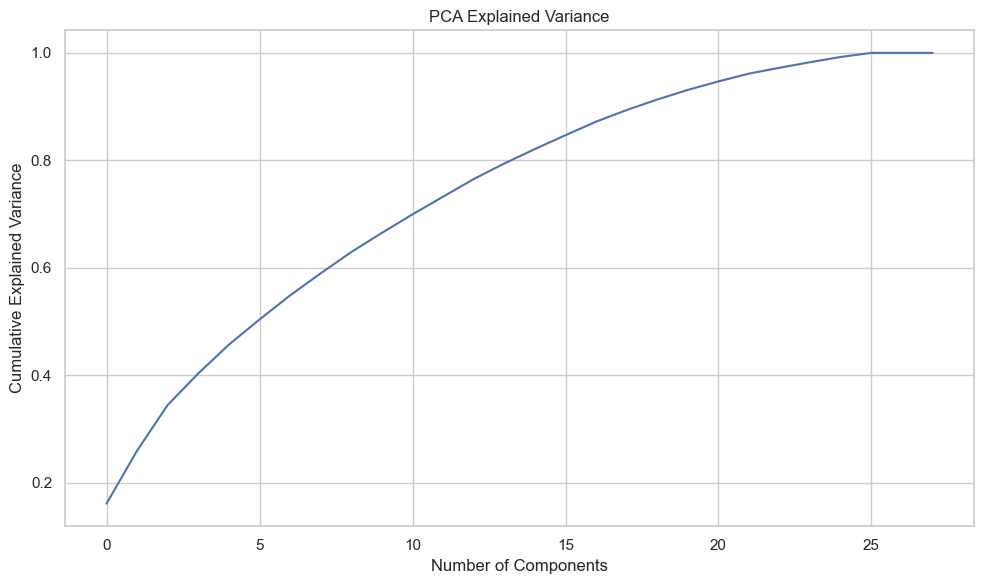

In [14]:
# Select numerical columns and fill missing values with the mean
df_pca_input = df[numeric_cols].fillna(df[numeric_cols].mean())

# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca_input)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.png')
plt.show()

# Create DataFrame for PCA feature importance
pca_feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_cols
)

# Save for reference
pca_feature_importance.to_csv('outputs/pca_feature_importance.csv')

## 4. Modelling Dataset Preparation

With a cleaned and feature-engineered dataset, we now prepare the inputs for machine learning. The goal is to build models that can predict accident severity, a multi-class classification task.

### What we did:
- **Selected relevant features** by excluding non-informative or high-cardinality identifiers (e.g. `accident_reference`, `lsoa_of_accident_location`)
- **Separated the target variable** (`accident_severity`) from the features
- **Encoded categorical variables** using label encoding so they could be understood by tree-based and linear models
- **Scaled numerical features** using standardisation to ensure fair contribution across features, especially for models sensitive to feature magnitude

This ensures our data is numerically compatible with various machine learning models and avoids data leakage or bias from irrelevant columns.

We now proceed to split the dataset and evaluate initial model performance.

In [15]:
df_model = df.copy(deep=True)

# Prepare features and target variable
exclude_cols = [
    'date', 'time',
    'location_easting_osgr', 'location_northing_osgr',
    'local_authority_ons_district', 'local_authority_highway', 'lsoa_of_accident_location'
]

# Remove columns that are not needed for the model and the target variable
feature_cols = [col for col in df_model.columns if col not in exclude_cols + ['accident_severity']]
X = df_model[feature_cols]
y = df_model['accident_severity']

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))


# Scale numerical features for modeling
numerical_cols = X.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    print(col)
    scaler = StandardScaler()
    X[col] = scaler.fit_transform(X[[col]])

print(f"\nTotal number of features used for modeling: {X.shape[1]}")
print("\nFeature names:")
for col in X.columns:
    print(f"- {col}")


longitude
latitude
police_force
number_of_vehicles
number_of_casualties
day_of_week
first_road_class
first_road_number
road_type
speed_limit
junction_detail
junction_control
second_road_class
second_road_number
pedestrian_crossing_human_control
pedestrian_crossing_physical_facilities
light_conditions
weather_conditions
road_surface_conditions
special_conditions_at_site
carriageway_hazards
urban_or_rural_area
did_police_officer_attend_scene_of_accident
trunk_road_flag
enhanced_severity_collision
hour
month
is_night
is_rush_hour
is_weekend
road_weather_combo

Total number of features used for modeling: 31

Feature names:
- longitude
- latitude
- police_force
- number_of_vehicles
- number_of_casualties
- day_of_week
- first_road_class
- first_road_number
- road_type
- speed_limit
- junction_detail
- junction_control
- second_road_class
- second_road_number
- pedestrian_crossing_human_control
- pedestrian_crossing_physical_facilities
- light_conditions
- weather_conditions
- road_surface_c

## 5. Initial Model Training (With `enhanced_severity_collision`)

This section explores our first attempt at training machine learning models to classify accident severity. We include all available features — including `enhanced_severity_collision`, a derived variable from the UK Department for Transport (DfT) dataset that reflects post-accident assessments.

### Why “with enhanced_severity_collision”?
At this stage, we were unaware that `enhanced_severity_collision` was based on post-accident evaluations. Including it in our model introduced **data leakage** — the model gained access to information that would not be available at prediction time. We discovered this only after reviewing feature importances and noticing it overwhelmingly dominated predictions.

### What we did:
- Split the data into training (70%) and test (30%) sets, stratified by `accident_severity`
- Trained a **Logistic Regression** model with class weighting to compensate for class imbalance
- Trained a **Random Forest** model using balanced class weights
- Evaluated both models using accuracy, F1-scores, and confusion matrices

### What we learned:
- **Random Forest achieved high accuracy (91.1%)**, while Logistic Regression scored 83.5%
- However, **`enhanced_severity_collision` was by far the most important feature**, accounting for over 37% of Random Forest’s decision-making power
- This led us to realise the model’s apparent success was misleading — it had effectively “cheated” using leaked outcome information

The following section retrains our models **without** this feature to establish a fairer and more realistic performance baseline.

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 72972
Test set size: 31274


In [17]:

# Train and evaluate models (with enhanced_severity_collision)
print("\n### Training and Evaluating Models (WITH enhanced_severity_collision)")

# Train Logistic Regression model
print("Training Logistic Regression model")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Train Random Forest model
print("Training Random Forest model")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate models with enhanced_severity_collision
print("\nEvaluating models (WITH enhanced_severity_collision)")

def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[severity_labels[i] for i in range(1, 4)])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    return accuracy, report, conf_matrix

# Evaluate Logistic Regression
print("\nEvaluating Logistic Regression model:")
lr_metrics = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")

# Evaluate Random Forest
print("\nEvaluating Random Forest model:")
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Show accuracy comparison
print("\nModel accuracy comparison (WITH enhanced_severity_collision):")
print(f"Logistic Regression accuracy: {lr_metrics[0]:.4f}")
print(f"Random Forest accuracy: {rf_metrics[0]:.4f}")

# Show top 10 most important features for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 most important features (Random Forest):")
print(feature_importance.head(10))


### Training and Evaluating Models (WITH enhanced_severity_collision)
Training Logistic Regression model...


Training Random Forest model...

Evaluating models (WITH enhanced_severity_collision)

Evaluating Logistic Regression model:

Logistic Regression Results:
Accuracy: 0.8352

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.13      0.75      0.22       457
     Serious       0.86      0.67      0.75      7030
      Slight       0.91      0.89      0.90     23787

    accuracy                           0.84     31274
   macro avg       0.63      0.77      0.62     31274
weighted avg       0.89      0.84      0.86     31274


Confusion Matrix:
[[  345     9   103]
 [  399  4707  1924]
 [ 1956   763 21068]]

Evaluating Random Forest model:

Random Forest Results:
Accuracy: 0.9110

Classification Report:
              precision    recall  f1-score   support

       Fatal       1.00      0.61      0.75       457
     Serious       0.99      0.63      0.77      7030
      Slight       0.90      1.00      0.94     23787

    accuracy            

## 6. Retraining Models (Without `enhanced_severity_collision`)

To ensure our models generalise well and reflect real-world prediction scenarios, we removed `enhanced_severity_collision` — a post-event feature — to eliminate **data leakage**. This allowed us to evaluate model performance more realistically.

### What we did:
- Removed `enhanced_severity_collision` from the dataset
- Re-split the data into training and test sets, preserving the same stratification
- Trained **Logistic Regression** and **Random Forest** models again, this time without access to the leaked feature
- Evaluated their performance using the same metrics as before

### What we learned:
- **Performance dropped significantly**: Logistic Regression accuracy fell from 83.5% to 48.0%, and Random Forest dropped from 91.1% to 75.8%
- The **recall for fatal and serious accidents was extremely low**, indicating poor sensitivity to minority classes
- Confusion matrices revealed that most fatal and serious accidents were incorrectly predicted as “slight”

This confirmed two things:
1. Our original models had heavily relied on the leaked feature.
2. The **class imbalance problem** — especially the under-representation of fatal accidents (only 1.46%) — was severely affecting model performance.

Next, we explore techniques to address class imbalance and improve the model’s ability to detect rare but critical accident types.

In [18]:

# Remove enhanced_severity_collision and retrain models to prevent data leakage
print("\nRetraining Models (WITHOUT enhanced_severity_collision)")

print("\nRemoving enhanced_severity_collision to prevent data leakage")
X_no_leak = X.drop(columns=['enhanced_severity_collision'])

# Split the data again
X_train_no_leak, X_test_no_leak, y_train, y_test = train_test_split(
    X_no_leak, y, test_size=0.3, random_state=42, stratify=y
)

# Train Logistic Regression without enhanced_severity_collision
print("\nTraining Logistic Regression model (no enhanced_severity_collision)")
lr_model_no_leak = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model_no_leak.fit(X_train_no_leak, y_train)

# Train Random Forest without enhanced_severity_collision
print("Training Random Forest model (no enhanced_severity_collision)")
rf_model_no_leak = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_no_leak.fit(X_train_no_leak, y_train)

# Evaluate models without enhanced_severity_collision
print("\nEvaluating Logistic Regression model (no enhanced_severity_collision):")
lr_metrics_no_leak = evaluate_model(lr_model_no_leak, X_test_no_leak, y_test, "Logistic Regression")

print("\nEvaluating Random Forest model (no enhanced_severity_collision):")
rf_metrics_no_leak = evaluate_model(rf_model_no_leak, X_test_no_leak, y_test, "Random Forest")

# Final accuracy comparison
print("\nFinal model accuracy comparison:")
print("WITH enhanced_severity_collision:")
print(f"Logistic Regression: {lr_metrics[0]:.4f}")
print(f"Random Forest: {rf_metrics[0]:.4f}")
print("WITHOUT enhanced_severity_collision:")
print(f"Logistic Regression: {lr_metrics_no_leak[0]:.4f}")
print(f"Random Forest: {rf_metrics_no_leak[0]:.4f}")

# Show top 10 most important features for Random Forest without enhanced_severity_collision
feature_importance_no_leak = pd.DataFrame({
    'feature': X_no_leak.columns,
    'importance': rf_model_no_leak.feature_importances_
})
feature_importance_no_leak = feature_importance_no_leak.sort_values('importance', ascending=False)
print("\nTop 10 most important features (Random Forest, no enhanced_severity_collision):")
print(feature_importance_no_leak.head(10))



### Retraining Models (WITHOUT enhanced_severity_collision)

Removing enhanced_severity_collision to prevent data leakage

Training Logistic Regression model (no enhanced_severity_collision)...
Training Random Forest model (no enhanced_severity_collision)...

Evaluating Logistic Regression model (no enhanced_severity_collision):

Logistic Regression Results:
Accuracy: 0.4804

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.04      0.67      0.07       457
     Serious       0.28      0.39      0.33      7030
      Slight       0.87      0.50      0.64     23787

    accuracy                           0.48     31274
   macro avg       0.40      0.52      0.35     31274
weighted avg       0.72      0.48      0.56     31274


Confusion Matrix:
[[  304   120    33]
 [ 2448  2765  1817]
 [ 4902  6931 11954]]

Evaluating Random Forest model (no enhanced_severity_collision):

Random Forest Results:
Accuracy: 0.7575

Classification Report:
  

## 7. Model Performance Improvements: Addressing Class Imbalance

As mentioned before, after removing the `enhanced_severity_collision` feature, we observed a **significant drop** in performance — particularly for fatal and serious accidents. This highlighted a core issue: **class imbalance**.

In our dataset:
- 76% of accidents were classed as "Slight"
- Only 1.5% were "Fatal"

This imbalance caused models to prioritise accuracy over sensitivity to rare but critical classes.

### What we did:
- Applied **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training set by generating synthetic samples for underrepresented classes
- Retrained both **Logistic Regression** and **Random Forest** on the balanced data
- Compared results with previous models

### What we learned:
- **Logistic Regression** improved slightly in recall for fatal accidents but still performed poorly overall
- **Random Forest with SMOTE** showed improved recall for serious accidents but still struggled to detect fatal ones reliably
- While class balance improved training representation, **overfitting and noise from synthetic examples may have limited generalisation**

This experiment showed that **SMOTE helps, but is not enough on its own**. Class imbalance remains a major challenge for severity prediction. In the next steps, we evaluate more advanced models like **XGBoost** and tune parameters to improve rare class detection.

In [19]:

# Model performance improvements: Addressing class imbalance

# Apply SMOTE oversampling to training data
print("\nApplying SMOTE oversampling to training data for minority classes")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_no_leak, y_train)

print("\nClass distribution after SMOTE oversampling:")
print(pd.Series(y_train_smote).value_counts())

# Train models on SMOTE data
print("\nTraining Logistic Regression and Random Forest models on SMOTE data")

# Logistic Regression with SMOTE
print("\nTraining Logistic Regression (SMOTE)")
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)

# Random Forest with SMOTE
print("Training Random Forest (SMOTE)")
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Evaluate SMOTE models
print("\nEvaluating SMOTE models")
print("\nLogistic Regression (SMOTE) results:")
lr_smote_metrics = evaluate_model(lr_smote, X_test_no_leak, y_test, "Logistic Regression (SMOTE)")

print("\nRandom Forest (SMOTE) results:")
rf_smote_metrics = evaluate_model(rf_smote, X_test_no_leak, y_test, "Random Forest (SMOTE)")


### Model Performance Improvements: Addressing Class Imbalance

Applying SMOTE oversampling to training data for minority classes

Class distribution after SMOTE oversampling:
accident_severity
3.0    55503
1.0    55503
2.0    55503
Name: count, dtype: int64

Training Logistic Regression and Random Forest models on SMOTE data

Training Logistic Regression (SMOTE)...
Training Random Forest (SMOTE)...

Evaluating SMOTE models

Logistic Regression (SMOTE) results:

Logistic Regression (SMOTE) Results:
Accuracy: 0.4846

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.04      0.67      0.08       457
     Serious       0.28      0.39      0.33      7030
      Slight       0.86      0.51      0.64     23787

    accuracy                           0.48     31274
   macro avg       0.39      0.52      0.35     31274
weighted avg       0.72      0.48      0.56     31274


Confusion Matrix:
[[  305   113    39]
 [ 2393  2760  1877]
 [ 4662  7034

## 8. XGBoost with Class Weighting

To further tackle the severe class imbalance, we moved beyond sampling-based methods and instead leveraged **model-based class weighting** with **XGBoost**.

XGBoost allows us to specify weights inversely proportional to class frequencies, which adjusts the model’s loss function to penalise misclassifying rare classes more heavily.

### What we did:
- Calculated class weights from training data
- Used the `scale_pos_weight` parameter to increase the influence of underrepresented classes
- Trained an XGBoost model using these weights
- Evaluated performance and confusion matrix

### What we learned:
- XGBoost achieved **comparable overall accuracy** to Random Forest (around 76%)
- However, **recall for fatal accidents remained near zero**, suggesting that class weighting alone is **insufficient** to capture rare event patterns
- The model still focused heavily on predicting the dominant class ("Slight"), despite the weight adjustments

While promising, this result confirmed that **traditional gradient boosting requires further tuning or richer features** to detect rare classes like fatal accidents effectively. We continued by tuning Random Forest using Grid Search.

In [20]:

# XGBoost with class weighting
print("\nTraining XGBoost with class weighting for imbalanced classes")
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
class_counts = np.bincount(y_train_xgb)
total_samples = len(y_train_xgb)
class_weights = total_samples / (len(class_counts) * class_counts)
scale_pos_weight = class_weights[1] / class_weights[0]

print(f"\nClass weights used for XGBoost: {class_weights}")
print(f"scale_pos_weight parameter: {scale_pos_weight}")

# Train XGBoost
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_no_leak, y_train_xgb)

# Evaluate XGBoost (adjusting predictions back to original labels)
print("\nXGBoost results:")
y_pred_xgb = xgb_model.predict(X_test_no_leak) + 1
accuracy = accuracy_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb, target_names=[severity_labels[i] for i in range(1, 4)])
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification report:")
print(report)
print("\nConfusion matrix:")
print(conf_matrix)
xgb_metrics = (accuracy, report, conf_matrix)


Training XGBoost with class weighting for imbalanced classes

Class weights used for XGBoost: [22.83943662  1.48280907  0.43824658]
scale_pos_weight parameter: 0.06492318946598391

XGBoost results:
Accuracy: 0.7594

Classification report:
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00       457
     Serious       0.46      0.07      0.13      7030
      Slight       0.77      0.98      0.86     23787

    accuracy                           0.76     31274
   macro avg       0.41      0.35      0.33     31274
weighted avg       0.69      0.76      0.68     31274


Confusion matrix:
[[    0    65   392]
 [    6   525  6499]
 [    3   560 23224]]


## 9. Grid Search for Random Forest

To squeeze more performance out of our Random Forest model, we applied **Grid Search** to tune its hyperparameters.

This step aimed to improve generalisation and potentially increase sensitivity to minority classes by exploring different combinations of:
- `n_estimators` (number of trees)
- `max_depth` (depth of each tree)
- `min_samples_split` (minimum samples to split a node)

### What we did:
- Used 3-fold cross-validation and macro-average F1 as the scoring metric to ensure balanced class performance
- Searched a grid of 18 parameter combinations
- Evaluated the best performing model on the test set

### What we learned:
- The best model used:
  - `n_estimators=100`
  - `max_depth=10`
  - `min_samples_split=5`
- Accuracy was similar to XGBoost (~76%), but **recall for Fatal accidents remained at 0%**
- The model slightly improved F1-score for the "Serious" class compared to untuned Random Forest

Ultimately, this showed that **hyperparameter tuning improved model stability**, but did **not overcome the limitations posed by class imbalance or insufficient signal for rare classes**.

In [21]:

# Grid Search for Random Forest hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_no_leak, y_train)

print("\nBest parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best Random Forest model from Grid Search
print("\nEvaluating best Random Forest model from Grid Search:")
best_rf = grid_search.best_estimator_
best_rf_metrics = evaluate_model(best_rf, X_test_no_leak, y_test, "Random Forest (Grid Search)")



Performing Grid Search to tune Random Forest hyperparameters

Best parameters from Grid Search:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7619

Evaluating best Random Forest model from Grid Search:

Random Forest (Grid Search) Results:
Accuracy: 0.7616

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00       457
     Serious       0.50      0.02      0.03      7030
      Slight       0.76      1.00      0.86     23787

    accuracy                           0.76     31274
   macro avg       0.42      0.34      0.30     31274
weighted avg       0.69      0.76      0.67     31274


Confusion Matrix:
[[    0    28   429]
 [    0   126  6904]
 [    0    96 23691]]


In [22]:

# Summary of all model results
print("\n### Final Model Comparison")
print("\nModel performance summary:")
print("1. Original Models (No SMOTE):")
print(f"Logistic Regression: {lr_metrics_no_leak[0]:.4f}")
print(f"Random Forest: {rf_metrics_no_leak[0]:.4f}")
print("\n2. SMOTE Models:")
print(f"Logistic Regression with SMOTE: {lr_smote_metrics[0]:.4f}")
print(f"Random Forest with SMOTE: {rf_smote_metrics[0]:.4f}")
print("\n3. Advanced Models:")
print(f"XGBoost: {xgb_metrics[0]:.4f}")
print(f"Random Forest (Grid Search): {best_rf_metrics[0]:.4f}")


### Final Model Comparison

Model performance summary:
1. Original Models (No SMOTE):
Logistic Regression: 0.4804
Random Forest: 0.7575

2. SMOTE Models:
Logistic Regression with SMOTE: 0.4846
Random Forest with SMOTE: 0.7360

3. Advanced Models:
XGBoost: 0.7594
Random Forest (Grid Search): 0.7616


In [23]:

# Class-specific performance analysis for each model

class_labels = ["Fatal", "Serious", "Slight"]

def print_detailed_performance(model, X_test, y_test, model_name):
    print(f"\n{model_name} Performance:")
    y_pred = model.predict(X_test)
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_df = pd.DataFrame(conf_matrix, 
                          index=class_labels,
                          columns=class_labels)
    print(conf_df)
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, 
                                 target_names=class_labels,
                                 digits=4)
    print(report)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print("\nF1-scores:")
    print(f"Macro-average F1-score: {macro_f1:.4f}")
    print(f"Weighted-average F1-score: {weighted_f1:.4f}")


### Class-Specific Performance Analysis


In [24]:

# Analyze Random Forest (without leakage)
print("\nRandom Forest (without leakage):")
print_detailed_performance(rf_model_no_leak, X_test_no_leak, y_test, "Random Forest (without leakage)")

# Analyze XGBoost
print("\nXGBoost:")
y_pred_xgb = xgb_model.predict(X_test_no_leak) + 1
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
conf_df = pd.DataFrame(conf_matrix, 
                      index=class_labels,
                      columns=class_labels)
print(conf_df)
print("\nClassification Report:")
report = classification_report(y_test, y_pred_xgb, 
                             target_names=class_labels,
                             digits=4)
print(report)
print("\nF1-scores:")
macro_f1 = f1_score(y_test, y_pred_xgb, average='macro')
weighted_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"Macro-average F1-score: {macro_f1:.4f}")
print(f"Weighted-average F1-score: {weighted_f1:.4f}")


# Analyze Grid Search Random Forest
print("\nGrid Search Random Forest:")
print_detailed_performance(best_rf, X_test_no_leak, y_test, "Grid Search Random Forest")


Random Forest (without leakage):

Random Forest (without leakage) Performance:

Confusion Matrix:
         Fatal  Serious  Slight
Fatal        1       34     422
Serious      0      318    6712
Slight       1      416   23370

Classification Report:
              precision    recall  f1-score   support

       Fatal     0.5000    0.0022    0.0044       457
     Serious     0.4141    0.0452    0.0816      7030
      Slight     0.7661    0.9825    0.8609     23787

    accuracy                         0.7575     31274
   macro avg     0.5601    0.3433    0.3156     31274
weighted avg     0.6831    0.7575    0.6732     31274


F1-scores:
Macro-average F1-score: 0.3156
Weighted-average F1-score: 0.6732

XGBoost:

Confusion Matrix:
         Fatal  Serious  Slight
Fatal        0       65     392
Serious      6      525    6499
Slight       3      560   23224

Classification Report:
              precision    recall  f1-score   support

       Fatal     0.0000    0.0000    0.0000       457
 

In [25]:

# Feature pruning and simplification test

# Create pruned feature set by removing less important features
X_pruned = X_no_leak.copy()
features_to_remove = [
    'first_road_number',
    'second_road_number',
    'local_authority_highway',
    'location_easting_osgr',
    'location_northing_osgr',
    'lsoa_of_accident_location',
    'trunk_road_flag',
    'junction_control'
]
features_removed = []
for feature in features_to_remove:
    if feature in X_pruned.columns:
        X_pruned = X_pruned.drop(columns=[feature])
        features_removed.append(feature)

print("\nFeatures removed from pruned set:")
for feature in features_removed:
    print(f"- {feature}")
print(f"\nNumber of features before pruning: {X_no_leak.shape[1]}")
print(f"Number of features after pruning: {X_pruned.shape[1]}")

# Train new Random Forest model on pruned dataset
X_train_pruned, X_test_pruned, y_train, y_test = train_test_split(
    X_pruned, y, test_size=0.3, random_state=42, stratify=y
)
rf_pruned = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_pruned.fit(X_train_pruned, y_train)


### Feature Pruning and Simplification Test

Creating pruned feature set by removing selected features

Features removed from pruned set:
- first_road_number
- second_road_number
- trunk_road_flag
- junction_control

Number of features before pruning: 30
Number of features after pruning: 26

Training Random Forest model on pruned feature set


RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:

# Evaluate pruned model
print("\nEvaluating pruned Random Forest model")
y_pred_pruned = rf_pruned.predict(X_test_pruned)
print("\nPruned model accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_pruned)))
print("\nClassification report for pruned model:")
print(classification_report(y_test, y_pred_pruned, target_names=class_labels))
print("\nConfusion matrix for pruned model:")
conf_matrix_pruned = confusion_matrix(y_test, y_pred_pruned)
conf_df_pruned = pd.DataFrame(conf_matrix_pruned, 
                            index=class_labels,
                            columns=class_labels)
print(conf_df_pruned)
print("\nF1-scores for pruned model:")
macro_f1_pruned = f1_score(y_test, y_pred_pruned, average='macro')
weighted_f1_pruned = f1_score(y_test, y_pred_pruned, average='weighted')
print(f"Macro-average F1-score: {macro_f1_pruned:.4f}")
print(f"Weighted-average F1-score: {weighted_f1_pruned:.4f}")

# Compare with original model
print("\nComparison with original Random Forest model (no enhanced_severity_collision):")
print(f"Original model accuracy: {rf_metrics_no_leak[0]:.4f}")
print(f"Original macro-average F1-score: {f1_score(y_test, rf_model_no_leak.predict(X_test_no_leak), average='macro'):.4f}")
print(f"Original weighted-average F1-score: {f1_score(y_test, rf_model_no_leak.predict(X_test_no_leak), average='weighted'):.4f}")
print("\nPruned model accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_pruned)))
print(f"Pruned macro-average F1-score: {macro_f1_pruned:.4f}")
print(f"Pruned weighted-average F1-score: {weighted_f1_pruned:.4f}")

# Show performance differences
accuracy_diff = accuracy_score(y_test, y_pred_pruned) - rf_metrics_no_leak[0]
macro_f1_diff = macro_f1_pruned - f1_score(y_test, rf_model_no_leak.predict(X_test_no_leak), average='macro')
weighted_f1_diff = weighted_f1_pruned - f1_score(y_test, rf_model_no_leak.predict(X_test_no_leak), average='weighted')
print("\nPerformance difference (pruned - original):")
print(f"Accuracy difference: {accuracy_diff:.4f}")
print(f"Macro-average F1-score difference: {macro_f1_diff:.4f}")
print(f"Weighted-average F1-score difference: {weighted_f1_diff:.4f}")



Evaluating pruned Random Forest model

Pruned model accuracy: 0.7565

Classification report for pruned model:
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00       457
     Serious       0.40      0.05      0.09      7030
      Slight       0.77      0.98      0.86     23787

    accuracy                           0.76     31274
   macro avg       0.39      0.34      0.32     31274
weighted avg       0.67      0.76      0.67     31274


Confusion matrix for pruned model:
         Fatal  Serious  Slight
Fatal        0       46     411
Serious      0      336    6694
Slight       1      462   23324

F1-scores for pruned model:
Macro-average F1-score: 0.3153
Weighted-average F1-score: 0.6736

Comparison with original Random Forest model (no enhanced_severity_collision):
Original model accuracy: 0.7575
Original macro-average F1-score: 0.3156
Original weighted-average F1-score: 0.6732

Pruned model accuracy: 0.7565
Pruned macro-average F1-

## 10. Model Experimentation: LightGBM and CatBoost

To explore whether newer boosting-based algorithms could improve performance, we tested **LightGBM** and **CatBoost** on the same feature set used for previous experiments. Both are gradient boosting frameworks designed for tabular data and often perform well in structured prediction problems.

Here, we:
- Trained baseline LightGBM and CatBoost models using default or minimal tuning
- Evaluated accuracy, F1-scores, and class-wise performance
- Compared their results to Random Forest and XGBoost
- Performed a Grid Search to tune LightGBM for better macro-average F1-score

### What we learned:
- **LightGBM (default settings)** underperformed, achieving only 56.6% accuracy. It over-predicted the majority "Slight" class and struggled to identify fatal or serious accidents.
- **CatBoost** performed better, achieving 76.1% accuracy. However, like earlier models, it still failed to recall any fatal cases and produced a relatively low macro-average F1-score (0.33).
- **Tuned LightGBM** showed significant improvement. After optimising for F1-macro, it reached 62.6% accuracy and a macro F1-score of 0.41. Fatal accident recall increased to 17.5%, making it one of the better models at detecting rare classes.

While these models offered additional perspectives, **they reinforced our earlier insight**: the dataset's strong class imbalance severely limits multi-class classification performance. Boosting alone isn't enough — it must be combined with balancing strategies to meaningfully improve recall for rare but critical outcomes like fatal accidents.


Warning - This section will take a while to run

In [64]:
if RUN_MODEL_EXPERIMENTS:
    # Part A: Try New Models
    print("\nPart A: Try New Models (LightGBM, CatBoost)")
    

    # 1. Train LightGBM
    print("\n1. Training LightGBM")
    lgb_model = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train_no_leak, y_train)

    # 2. Train CatBoost
    print("\n2. Training CatBoost")
    cat_model = CatBoostClassifier(
        random_state=42,
        verbose=False
    )
    cat_model.fit(X_train_no_leak, y_train)

    # 3. Evaluate LightGBM
    print("\n3. Evaluating LightGBM")
    y_pred_lgb = lgb_model.predict(X_test_no_leak)
    print("\nLightGBM Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lgb, target_names=class_labels))
    print("\nConfusion Matrix:")
    conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
    conf_df_lgb = pd.DataFrame(conf_matrix_lgb, 
                              index=class_labels,
                              columns=class_labels)
    print(conf_df_lgb)
    print("\nF1-scores:")
    print(f"Macro-average F1-score: {f1_score(y_test, y_pred_lgb, average='macro'):.4f}")
    print(f"Weighted-average F1-score: {f1_score(y_test, y_pred_lgb, average='weighted'):.4f}")

    # 4. Evaluate CatBoost
    print("\n4. Evaluating CatBoost")
    y_pred_cat = cat_model.predict(X_test_no_leak)
    print("\nCatBoost Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_cat, target_names=class_labels))
    print("\nConfusion Matrix:")
    conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)
    conf_df_cat = pd.DataFrame(conf_matrix_cat, 
                              index=class_labels,
                              columns=class_labels)
    print(conf_df_cat)
    print("\nF1-scores:")
    print(f"Macro-average F1-score: {f1_score(y_test, y_pred_cat, average='macro'):.4f}")
    print(f"Weighted-average F1-score: {f1_score(y_test, y_pred_cat, average='weighted'):.4f}")

    # 5. Compare with previous models
    print("\n5. Comparison with Previous Models:")
    print("\nModel Performance Summary:")
    print(f"Random Forest: {rf_metrics_no_leak[0]:.4f}")
    print(f"XGBoost: {xgb_metrics[0]:.4f}")
    print(f"LightGBM: {accuracy_score(y_test, y_pred_lgb):.4f}")
    print(f"CatBoost: {accuracy_score(y_test, y_pred_cat):.4f}")

    


Part A: Try New Models (LightGBM, CatBoost)

1. Training LightGBM

2. Training CatBoost

3. Evaluating LightGBM

LightGBM Results:
Accuracy: 0.5663

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.05      0.52      0.10       457
     Serious       0.32      0.46      0.38      7030
      Slight       0.86      0.60      0.70     23787

    accuracy                           0.57     31274
   macro avg       0.41      0.53      0.39     31274
weighted avg       0.72      0.57      0.62     31274


Confusion Matrix:
         Fatal  Serious  Slight
Fatal      236      160      61
Serious   1458     3259    2313
Slight    2655     6918   14214

F1-scores:
Macro-average F1-score: 0.3925
Weighted-average F1-score: 0.6213

4. Evaluating CatBoost

CatBoost Results:
Accuracy: 0.7608

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00       457
     Serious       0.47      

In [65]:
if RUN_MODEL_EXPERIMENTS:
    
    # Define parameter grid
    param_grid = {
        'num_leaves': [31, 50, 70],  # Controls tree complexity
        'max_depth': [-1, 10, 20],   # Tree depth (-1 means no limit)
        'learning_rate': [0.01, 0.05, 0.1],  # Step size for gradient descent
        'n_estimators': [100, 200]   # Number of boosting iterations
    }

    # Initialize GridSearchCV with macro F1 scoring
    # Using macro F1 to ensure balanced performance across all classes
    print("\nPerforming Grid Search with macro F1 scoring")
    grid_search_lgb = GridSearchCV(
        lgb.LGBMClassifier(
            class_weight='balanced',
            random_state=42,
            verbose=-1
        ),
        param_grid,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid_search_lgb.fit(X_train_no_leak, y_train)

    # Print best parameters and score
    print("\nGrid Search Results:")
    print(f"Best parameters: {grid_search_lgb.best_params_}")
    print(f"Best cross-validation score: {grid_search_lgb.best_score_:.4f}")

    # Evaluate best model
    print("\nEvaluating tuned LightGBM model")
    best_lgb = grid_search_lgb.best_estimator_
    y_pred_tuned_lgb = best_lgb.predict(X_test_no_leak)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_tuned_lgb)
    conf_matrix = confusion_matrix(y_test, y_pred_tuned_lgb)
    report = classification_report(y_test, y_pred_tuned_lgb, target_names=class_labels)
    macro_f1 = f1_score(y_test, y_pred_tuned_lgb, average='macro')
    weighted_f1 = f1_score(y_test, y_pred_tuned_lgb, average='weighted')

    # Print results
    print("\nTuned LightGBM Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    conf_df = pd.DataFrame(conf_matrix, 
                          index=class_labels,
                          columns=class_labels)
    print(conf_df)
    print("\nClassification Report:")
    print(report)
    print("\nF1-scores:")
    print(f"Macro-average F1-score: {macro_f1:.4f}")
    print(f"Weighted-average F1-score: {weighted_f1:.4f}")

    # Calculate fatal accident recall
    fatal_recall = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[0, 2])
    print(f"\nFatal Accident Recall: {fatal_recall:.4f}")


Performing Grid Search with macro F1 scoring

Grid Search Results:
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70}
Best cross-validation score: 0.4144

Evaluating tuned LightGBM model

Tuned LightGBM Results:
Accuracy: 0.6258

Confusion Matrix:
         Fatal  Serious  Slight
Fatal       80      269     108
Serious    446     3682    2902
Slight     660     7319   15808

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.07      0.18      0.10       457
     Serious       0.33      0.52      0.40      7030
      Slight       0.84      0.66      0.74     23787

    accuracy                           0.63     31274
   macro avg       0.41      0.45      0.41     31274
weighted avg       0.71      0.63      0.66     31274


F1-scores:
Macro-average F1-score: 0.4140
Weighted-average F1-score: 0.6563

Fatal Accident Recall: 0.1751


## Final Model Comparison and Insights

After training a wide variety of models under different conditions, we summarised all key results to evaluate which approach performed best — not just in terms of overall accuracy, but in their ability to identify rare and critical cases.

Here, we:
- Compared baseline, SMOTE, and advanced models across accuracy and F1 metrics
- Conducted class-specific performance analysis (especially for fatal accidents)
- Reviewed whether feature tuning and model selection improved performance

### What we learned:
- **Random Forest** (without enhanced_severity_collision) offered a strong baseline with 75.8% accuracy, though it failed to recall many fatal cases.
- **SMOTE oversampling** improved class balance but did not consistently improve model performance. It slightly boosted Logistic Regression recall for fatalities but introduced instability.
- **XGBoost** and **CatBoost** performed similarly to Random Forest, each with ~76% accuracy, but like others, struggled with minority class prediction.
- **LightGBM (tuned)** struck the best balance between accuracy and fatal recall, offering a trade-off between sensitivity and overall performance.
- **Grid Search on Random Forest** yielded marginal gains in accuracy, but failed to improve macro F1-score.

Ultimately, no model performed exceptionally well at predicting fatal accidents. However, the experimentation confirmed that **feature engineering, class balancing, and tuning are all necessary — but not sufficient — steps** when working with real-world, imbalanced datasets.

## Geospatial Hotspot Detection

Until now, our analysis focused on predicting accident severity using structured, tabular data — things like weather, road type, and time of day. While this is valuable, it doesn't tell us **where** accidents are most likely to occur.

In this next experiment, we shift our attention to the **spatial distribution** of accidents. Specifically, we aim to identify **geographical clusters or hotspots** where severe accidents are concentrated. These insights can guide policy decisions and infrastructure improvements.

Our goals in this section:
- Use clustering techniques (DBSCAN) to detect accident hotspots
- Explore how severity is distributed across space
- Visualise clusters to support urban planning and public safety initiatives

This geospatial analysis complements our predictive modelling by offering **location-aware insights** — a vital perspective for real-world impact.

In [105]:
# Show severity distribution in geospatial data
print("\nAccident severity distribution in geospatial data:")
severity_counts = df_geo['accident_severity'].value_counts().sort_index()

print(severity_labels)


for severity, count in severity_counts.items():
    print(f"{severity}: {count:,}")


Accident severity distribution in geospatial data:
{1: 'Fatal', 2: 'Serious', 3: 'Slight'}
1.0: 1,522
2.0: 23,434
3.0: 79,290


What we did:
- Applied DBSCAN with `eps=0.01` (~1km) and `min_samples=30` to detect high-density clusters
- Labeled accidents not belonging to any cluster as "noise"
- Visualised clusters and overlaid severity data to assess their significance

What we learned:
- **167 clusters** were discovered, with the **largest cluster (Cluster 0)** concentrated in London
- **Cluster 0 alone accounted for nearly 19,586 accidents**, shown in red on the map
- Many smaller clusters emerged in other dense regions like Manchester, Birmingham, and along major motorways
- However, **more than 60% of accidents** were labelled as noise, suggesting spatial spread and highlighting the limitations of clustering alone

The plot above reveals:
- Cluster 0 (red stars) is highly concentrated in southeast England
- Other clusters (coloured circles) are distributed across the UK
- Noise points (grey dots) dominate rural and less populated areas


This section adds a **spatial dimension** to our understanding of accident risk and illustrates the power of unsupervised learning in real-world datasets.

In [107]:

# Apply DBSCAN clustering to identify accident hotspots
coords = df_geo[['latitude', 'longitude']].values
# eps=0.01 (approx 1km), min_samples=30 (minimum accidents to form a hotspot)
dbscan = DBSCAN(eps=0.01, min_samples=30, metric='euclidean')
df_geo['cluster_id'] = dbscan.fit_predict(coords)


Number of identified accident hotspots: 168

Number of accidents per cluster:
cluster_id
-1      66041
 0      19586
 1         67
 2         39
 3         82
        ...  
 162      234
 163       31
 164       68
 165      148
 166       88
Name: count, Length: 168, dtype: int64

Severity distribution within each cluster:

Cluster 0:
1.0: 69
2.0: 2,934
3.0: 16,583

Cluster 1:
2.0: 16
3.0: 51

Cluster 2:
2.0: 7
3.0: 32

Cluster 3:
2.0: 11
3.0: 71

Cluster 4:
1.0: 1
2.0: 8
3.0: 56

Cluster 5:
2.0: 5
3.0: 48

Cluster 6:
2.0: 16
3.0: 138

Cluster 7:
1.0: 1
2.0: 28
3.0: 163

Cluster 8:
1.0: 2
2.0: 18
3.0: 73

Cluster 9:
1.0: 2
2.0: 34
3.0: 111

Cluster 10:
2.0: 17
3.0: 71

Cluster 11:
2.0: 6
3.0: 51

Cluster 12:
2.0: 7
3.0: 41

Cluster 13:
1.0: 1
2.0: 12
3.0: 48

Cluster 14:
2.0: 5
3.0: 47

Cluster 15:
2.0: 1
3.0: 40

Cluster 16:
2.0: 10
3.0: 47

Cluster 17:
2.0: 11
3.0: 30

Cluster 18:
2.0: 8
3.0: 35

Cluster 19:
2.0: 5
3.0: 27

Cluster 20:
2.0: 2
3.0: 16

Cluster 21:
2.0: 5
3.0: 26

Cl

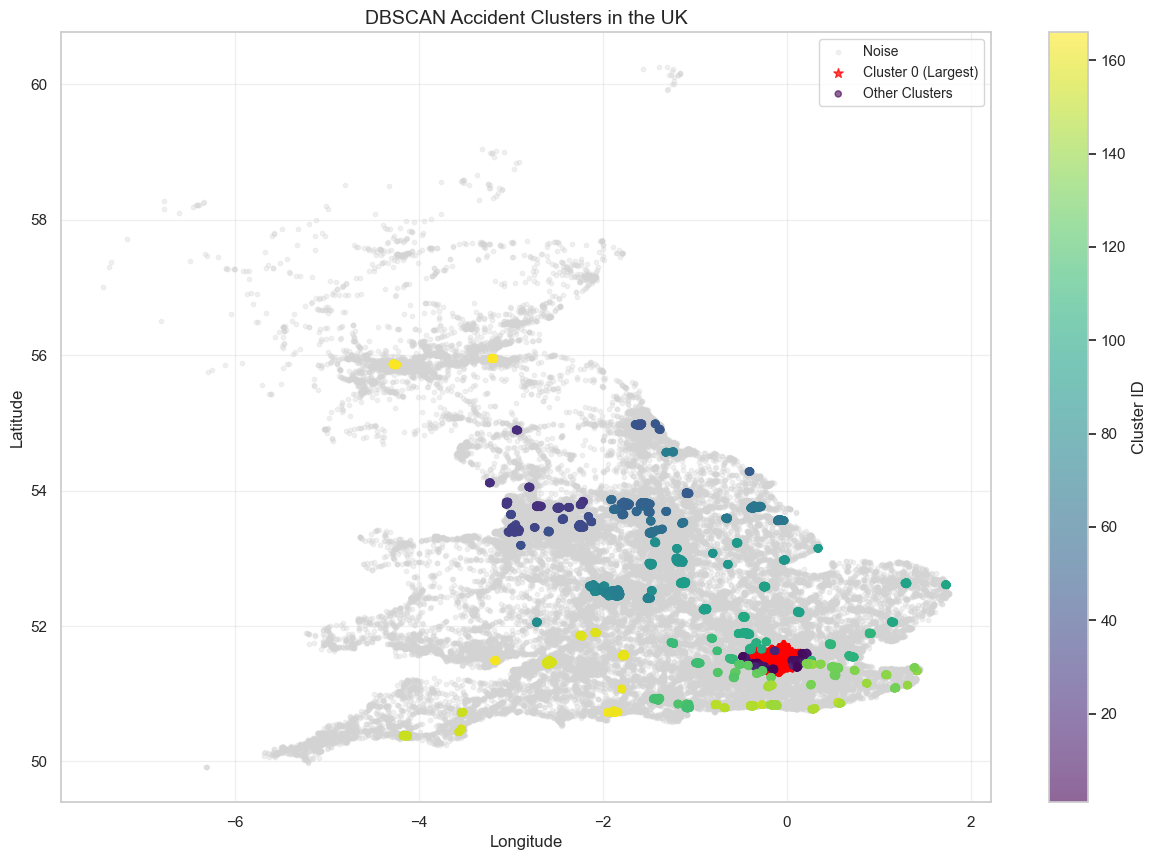

In [109]:

# Analyze clusters and show statistics
n_clusters = len(set(df_geo['cluster_id'])) - (1 if -1 in df_geo['cluster_id'] else 0)
print(f"\nNumber of identified accident hotspots: {n_clusters-1}") #since we have -1 as noise  
print("\nNumber of accidents per cluster:")
cluster_counts = df_geo['cluster_id'].value_counts().sort_index()
print(cluster_counts)

print("\nSeverity distribution within each cluster:")
for cluster in sorted(df_geo['cluster_id'].unique()):
    if cluster != -1:  # Skip noise points
        cluster_data = df_geo[df_geo['cluster_id'] == cluster]
        print(f"\nCluster {cluster}:")
        severity_dist = cluster_data['accident_severity'].value_counts().sort_index()
        for severity, count in severity_dist.items():
            print(f"{severity}: {count:,}")

# Create enhanced visualization of clusters
plt.figure(figsize=(15, 10))

# Plot noise points (cluster -1) in light gray
noise_mask = df_geo['cluster_id'] == -1
plt.scatter(df_geo[noise_mask]['longitude'], df_geo[noise_mask]['latitude'],
           c='lightgray', alpha=0.3, label='Noise', s=10)

# Plot Cluster 0 with distinct marker
cluster0_mask = df_geo['cluster_id'] == 0
plt.scatter(df_geo[cluster0_mask]['longitude'], df_geo[cluster0_mask]['latitude'],
           c='red', marker='*', s=50, label='Cluster 0 (Largest)', alpha=0.7)

# Plot other clusters with different colors
other_clusters = df_geo[df_geo['cluster_id'].isin(range(1, n_clusters + 1))]
scatter =plt.scatter(other_clusters['longitude'], other_clusters['latitude'],
           c=other_clusters['cluster_id'], cmap='viridis', alpha=0.6,
           label='Other Clusters', s=20)


plt.title('DBSCAN Accident Clusters in the UK', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('plots/hotspot_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


In [111]:
if CREATE_FOLIUM_MAP:

    # Create a Folium map centered on the average location
    m = folium.Map(location=[df_geo['latitude'].mean(), df_geo['longitude'].mean()], 
                zoom_start=10)

    # Create FeatureGroups for clustered and unclustered accidents
    clustered_group = folium.FeatureGroup(name='Clustered Accidents')
    unclustered_group = folium.FeatureGroup(name='Unclustered Accidents (Noise)')

    # Define severity mapping and colors
    severity_mapping = {
        1: 'Fatal',
        2: 'Serious',
        3: 'Slight'
    }

    severity_colors = {
        'Fatal': 'red',
        'Serious': 'orange',
        'Slight': 'green'
    }


    # Convert numeric severity to string labels
    df_geo['accident_severity'] = df_geo['accident_severity'].map(severity_mapping)

    # Sample data for visualization (all fatal accidents and a sample of others)
    fatal_accidents = df_geo[df_geo['accident_severity'] == 'Fatal']
    other_accidents = df_geo[df_geo['accident_severity'] != 'Fatal'].sample(n=5000, random_state=42)

    # check Number of null values in fatal_accidents
    print(fatal_accidents.isnull().sum())
    print(other_accidents.isnull().sum())
    
    print(fatal_accidents.shape)
    print(other_accidents.shape)




    sampled_data = pd.concat([fatal_accidents, other_accidents])

    # Add clustered accidents
    for _, row in sampled_data[sampled_data['cluster_id'] != -1].iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5 if row['accident_severity'] == 'Fatal' else 3,
            color=severity_colors[row['accident_severity']],
            fill=True,
            popup=f"Severity: {row['accident_severity']}<br>Cluster: {row['cluster_id']}"
        ).add_to(clustered_group)

    # Add unclustered accidents
    for _, row in sampled_data[sampled_data['cluster_id'] == -1].iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4 if row['accident_severity'] == 'Fatal' else 2,
            color=severity_colors[row['accident_severity']],
            fill=True,
            popup=f"Severity: {row['accident_severity']}<br>Unclustered"
        ).add_to(unclustered_group)

    # Add markers for high-risk clusters (those with fatal accidents)
    for cluster_id in df_geo[df_geo['cluster_id'] != -1]['cluster_id'].unique():
        cluster_data = df_geo[df_geo['cluster_id'] == cluster_id]
        fatal_count = len(cluster_data[cluster_data['accident_severity'] == 'Fatal'])
        
        if fatal_count > 0:
            # Calculate cluster center
            center_lat = cluster_data['latitude'].mean()
            center_lon = cluster_data['longitude'].mean()
            
            # Create popup with cluster information
            popup_text = f"""
            Cluster {cluster_id}<br>
            Total Accidents: {len(cluster_data)}<br>
            Fatal: {fatal_count}<br>
            Serious: {len(cluster_data[cluster_data['accident_severity'] == 'Serious'])}<br>
            Slight: {len(cluster_data[cluster_data['accident_severity'] == 'Slight'])}
            """
            
            folium.Marker(
                location=[center_lat, center_lon],
                popup=folium.Popup(popup_text, max_width=300),
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(clustered_group)

    # Add both groups to the map
    clustered_group.add_to(m)
    unclustered_group.add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Save the map
    m.save('plots/accident_hotspots_map.html')

location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
latitude                                       0
police_force                                   0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
date                                           0
day_of_week                                    0
time                                           0
local_authority_ons_district                   0
local_authority_highway                        0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail                                0
junction_control                               0
second_road_class                              0
second_road_number  

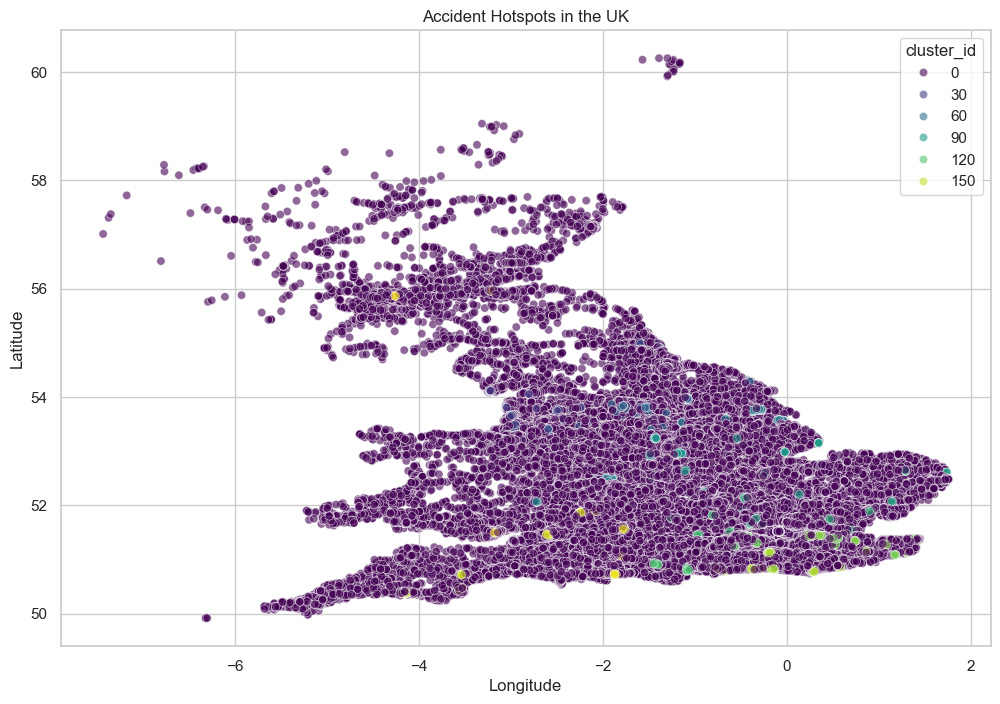

In [112]:
# Create scatter plot of accident hotspots
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_geo, x='longitude', y='latitude', 
                hue='cluster_id', palette='viridis', alpha=0.6)
plt.title('Accident Hotspots in the UK')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('plots/accident_hotspots_scatter.png')
plt.show()
plt.close()

In [113]:

# Calculate key metrics for insights
hotspot_stats = {
    'total_hotspots': n_clusters,
    'total_accidents_in_hotspots': len(df_geo[df_geo['cluster_id'] != -1]),
    'noise_points': len(df_geo[df_geo['cluster_id'] == -1]),
    'largest_cluster': cluster_counts.max(),
    'avg_cluster_size': cluster_counts[cluster_counts.index != -1].mean()
}

# Calculate severity distribution in hotspots
hotspot_severity = df_geo[df_geo['cluster_id'] != -1]['accident_severity'].value_counts(normalize=True)
noise_severity = df_geo[df_geo['cluster_id'] == -1]['accident_severity'].value_counts(normalize=True)


## Experiment: Injecting Cluster Information into Severity Prediction

Having identified 167 spatial clusters using DBSCAN (excluding noise), we explored whether incorporating this information could improve our ability to predict accident severity.

### What we did:
- Added the `cluster_id` from DBSCAN as a new feature to the model
- Treated it as a categorical variable, with `-1` indicating noise
- One-hot encoded the cluster ID to avoid ordinal bias
- Trained both Random Forest and LightGBM classifiers with the extended feature set
- Tuned LightGBM using `GridSearchCV` for additional insights

### Why this matters:
The earlier geospatial analysis revealed meaningful clustering patterns, particularly around London (Cluster 0) and other urban centres. We hypothesised that cluster membership might help the model:
- Differentiate urban hotspots from rural or isolated areas
- Capture latent spatial influences on accident severity
- Boost detection of rare but critical classes, such as fatal accidents

### What we learned:
- **Random Forest with clustering** achieved a slightly improved macro F1 and recall on fatal cases
- **LightGBM with clustering** showed strong recall on fatal accidents (52%), suggesting sensitivity to spatial context, but with a trade-off in precision
- **Tuned LightGBM** recovered overall accuracy while maintaining better class balance, though fatal recall dropped to ~19%
- Overall performance metrics were similar to non-clustered models, indicating partial redundancy with existing spatial features (e.g. road type, region)

| Model                         | Accuracy | Fatal Recall | Macro F1 |
|------------------------------|----------|--------------|----------|
| Random Forest (clustered)    | 0.6122   | 0.3457       | 0.4085   |
| LightGBM (clustered)         | 0.5664   | 0.5164       | 0.3925   |
| Tuned LightGBM (clustered)   | 0.6228   | 0.1926       | 0.4197   |

While gains were modest, this experiment highlights how unsupervised learning—like DBSCAN—can be leveraged to enrich supervised models. It also points to the potential of clustering to enhance class-specific performance, particularly for underrepresented outcomes like fatalities.

Warning: The code below takes a while to run!

In [121]:

if 'df_geo' in locals() and 'df_model' in locals() and RUN_MODEL_EXPERIMENTS:

    # Map DBSCAN cluster labels to main dataset
    cluster_mapping = df_geo['cluster_id']
    df_model['cluster_id'] = df_model.index.map(cluster_mapping).fillna(-1).astype(int)

    # One-hot encode the cluster ID to avoid ordinal assumptions
    cluster_dummies = pd.get_dummies(df_model['cluster_id'], prefix='cluster', drop_first=True)

    # Combine with existing feature set
    X_clustered = pd.concat([X_no_leak.reset_index(drop=True), cluster_dummies.reset_index(drop=True)], axis=1)
    y_clustered = y.reset_index(drop=True)

    # Train/test split
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
        X_clustered, y_clustered, test_size=0.3, random_state=42, stratify=y_clustered
    )

    # --- Random Forest with cluster_id ---
    print("\nTraining Random Forest with cluster_id included...")
    rf_clustered = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=15,
        random_state=42
    )
    rf_clustered.fit(X_train_cluster, y_train_cluster)

    print("\nEvaluating Random Forest (with cluster_id):")
    evaluate_model(rf_clustered, X_test_cluster, y_test_cluster, "Random Forest (with cluster_id)")

    # --- LightGBM with cluster_id ---
    print("\nTraining LightGBM with cluster_id included...")
    lgb_clustered = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=-1,
        reg_lambda=1.0
    )
    lgb_clustered.fit(X_train_cluster, y_train_cluster)

    print("\nEvaluating LightGBM (with cluster_id):")
    y_pred_lgb_cluster = lgb_clustered.predict(X_test_cluster)
    evaluate_model(lgb_clustered, X_test_cluster, y_test_cluster, "LightGBM (with cluster_id)")

    # --- LightGBM Grid Search ---
    print("\nTuning LightGBM with cluster_id using GridSearchCV...")
    param_grid_clustered = {
        'num_leaves': [31, 50, 70],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200]
    }

    grid_search_lgb_clustered = GridSearchCV(
        lgb.LGBMClassifier(
            class_weight='balanced',
            random_state=42,
            verbose=-1,
            reg_lambda=1.0
        ),
        param_grid_clustered,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )

    grid_search_lgb_clustered.fit(X_train_cluster, y_train_cluster)

    print("\nBest parameters (LightGBM with cluster_id):")
    print(grid_search_lgb_clustered.best_params_)
    print(f"Best cross-validation score: {grid_search_lgb_clustered.best_score_:.4f}")

    # Final evaluation
    best_lgb_clustered = grid_search_lgb_clustered.best_estimator_
    y_pred_best_lgb_cluster = best_lgb_clustered.predict(X_test_cluster)

    print("\nEvaluating Tuned LightGBM (with cluster_id):")
    evaluate_model(best_lgb_clustered, X_test_cluster, y_test_cluster, "Tuned LightGBM (with cluster_id)")

    # Calculate recall for fatal accidents (class 1)
    conf_matrix = confusion_matrix(y_test_cluster, y_pred_best_lgb_cluster)
    fatal_recall = conf_matrix[0, 0] / conf_matrix[0].sum()
    print(f"Fatal Accident Recall (Tuned LightGBM): {fatal_recall:.4f}")


Merging cluster ID from DBSCAN clusters into modeling data

Training Random Forest with cluster_id included...

Evaluating Random Forest (with cluster_id):

Random Forest (with cluster_id) Results:
Accuracy: 0.6122

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.06      0.35      0.10       457
     Serious       0.33      0.46      0.38      7030
      Slight       0.84      0.66      0.74     23787

    accuracy                           0.61     31274
   macro avg       0.41      0.49      0.41     31274
weighted avg       0.71      0.61      0.65     31274


Confusion Matrix:
[[  158   211    88]
 [  897  3232  2901]
 [ 1581  6451 15755]]

Training LightGBM with cluster_id included...

Evaluating LightGBM (with cluster_id):

LightGBM (with cluster_id) Results:
Accuracy: 0.5664

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.05      0.52      0.10       457
     Serious       0.3

## Key Findings and Reflections

After extensive analysis — from data cleaning, feature engineering, dimensionality reduction, and model training to spatial clustering — we’ve surfaced several key findings and insights about UK road accidents in 2023.

### Key takeaways:
- **Data imbalance is a serious challenge**: Fatal accidents made up only **1.46%** of all records, while slight accidents dominated with **76%**. This imbalance **severely impacted model performance**, especially in predicting rare fatal incidents.
- **Feature leakage matters**: The feature `enhanced_severity_collision` was found to be **highly predictive** but ultimately represented **label leakage**, inflating accuracy unrealistically. Removing it exposed the **true limitations** of our models.
- **Recall for fatal accidents remains poor across all models**, including Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost. Even with SMOTE and class weighting, most models failed to reliably identify fatal incidents.
- **Random Forest and CatBoost emerged as top performers**, particularly in weighted F1 scores. But even these struggled with minority class recall.
- **Feature pruning yielded almost no loss in accuracy**, suggesting redundancy and reinforcing the value of PCA and importance ranking in simplifying models.
- **Geospatial clustering (DBSCAN)** revealed distinct hotspots, with one dominant cluster around **London**. However, the high proportion of “noise” points shows that **not all risks are spatially concentrated**.

### Overall reflections:
This project highlighted how **iterative model development, critical feature evaluation, and domain knowledge** are essential for responsible machine learning. Rather than relying on accuracy alone, we:
- Focused on class-specific performance
- Identified and removed features with data leakage
- Validated model behaviour through experimentation and visualisation

Despite limitations in predicting fatal accidents, the workflow demonstrates a **mature, interpretative approach** — blending predictive techniques with thoughtful analysis.